## Оценка риска ДТП

Для каршеринговой компании нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства (кроме царапины). Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Задачи от заказчика: 
- Создать модель предсказания ДТП 
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- для моделирования ограничиться данными за 2012 год — они самые свежие.
- необходимо учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

In [1]:
!pip install sqlalchemy -q

!pip install phik -q
!pip install catboost -q
!pip install skorch -q
!pip install shap -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine 
import warnings
import plotly.express as px
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
import shap
from sklearn.utils import resample

In [3]:
# Уберем предупреждения, чтобы не отвлекали
warnings.simplefilter(action='ignore' )

In [4]:
RANDOM_STATE = 42

## Подключение к базе. Загрузка таблиц sql

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'password': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['password'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [7]:
engine = create_engine(connection_string) 

## Первичное исследование таблиц

Проверим все ли таблицы имеют набор данных

In [8]:
list_table=['case_ids', 'vehicles', 'collisions', 'parties']

In [9]:
for table in list_table:
    query = f"SELECT * FROM {table} LIMIT 3;"
    print(f"Таблица: {table}")
    df_query=pd.read_sql(query, engine)
    print (df_query)
    print()

Таблица: case_ids
   case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021

Таблица: vehicles
        id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  

Таблица: collisions
   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2        

Данные есть во всех таблицах

Условия нашей задачи:

Для модели выбрать **тип виновника — только машина (car)** *(таблица Parties , тип участника происшествия - PARTY_TYPE.)*

Выбрать случаи, когда ДТП привело к любым **повреждениям** транспортного средства, **кроме типа SCRATCH (царапина)** *(таблица collision, серьёзность происшествия	COLLISION_DAMAGE.)*

Для моделирования ограничиться **данными за 2012 год** — они самые свежие. *(таблица collisions, дата происшествия	COLLISION_DATE)*

Обязательное условие — учесть фактор **возраста автомобиля**. *(таблица Vehicles, возраст автомобиля (в годах) VEHICLE_AGE)* 

На основе модели исследовать основные **факторы ДТП**. *(таблица collisions, основной фактор аварии PRIMARY_COLL_FACTOR)*


Т.е. чтобы сформировапть правильный запрос, удовлетворяющим всем наших условиям, нам нужно использовать таблицы:
- parties,
- collision,
- vehicles

Для связи таблиц можно использовать общий ключ case_id. Все case_id хранятся в таблице case_ids. Однако для связи таблиц необязательно использовать таблицу case_ids.  Нужно учитывать логику связи. Так таблица collisions содержит одну запись на каждый case_id — описывает сам факт ДТП, а vehicles может содержать несколько записей на один case_id (если в ДТП участвуют несколько машин).

##  Статистический анализ факторов ДТП

Выясним, в какие месяцы происходит наибольшее количество аварий. 

Проанализируйте весь период наблюдений (таблица collisions).
Создайте sql-запрос;
Постройте график;
Сделайте вывод.

In [10]:
accident_per_month = """
SELECT DATE_TRUNC('month', COLLISION_DATE)::date AS month,
       COUNT(CASE_ID) AS count_accident
FROM collisions
GROUP BY DATE_TRUNC('month', COLLISION_DATE)::date
ORDER BY DATE_TRUNC('month', COLLISION_DATE)::date;
"""


df_accident_per_month =pd.read_sql(accident_per_month , engine)

In [11]:
df_accident_per_month

month  count_accident
0   2009-01-01           35062
1   2009-02-01           34480
2   2009-03-01           36648
3   2009-04-01           35239
4   2009-05-01           36916
5   2009-06-01           34202
6   2009-07-01           35161
7   2009-08-01           34508
8   2009-09-01           35555
9   2009-10-01           37835
10  2009-11-01           34562
11  2009-12-01           36060
12  2010-01-01           32892
13  2010-02-01           31918
14  2010-03-01           35803
15  2010-04-01           34416
16  2010-05-01           34862
17  2010-06-01           33367
18  2010-07-01           33645
19  2010-08-01           34620
20  2010-09-01           34957
21  2010-10-01           37480
22  2010-11-01           35460
23  2010-12-01           37070
24  2011-01-01           31926
25  2011-02-01           31975
26  2011-03-01           34585
27  2011-04-01           31377
28  2011-05-01           33370
29  2011-06-01           31962
30  2011-07-01           33029
31  2011-08-01           34339
32  2011-09-01           34137
33  2011-10-01           36618
34  2011-11-01           34495
35  2011-12-01           34615
36  2012-01-01           32020
37  2012-02-01           30377
38  2012-03-01           32498
39  2012-04-01           29143
40  2012-05-01           25168
41  2012-06-01            3062
42  2012-07-01             390
43  2012-08-01             622
44  2012-09-01             510
45  2012-10-01             304
46  2012-11-01             253
47  2012-12-01             200
48  2013-01-01             144
49  2013-02-01             108
50  2013-03-01              46
51  2013-04-01               5
52  2013-06-01               1
53  2013-07-01               1
54  2020-03-01               1
55  2020-07-01               1

Мы видим что у нас есть данные за неполный 2013 год и даже несколько строк за 2020. Для того правильно оценить количество аварий по месяцам оставим только полные приоды (ограничимся данными до 2013 года). 

In [12]:
df_accident_per_month['month'] = pd.to_datetime(df_accident_per_month['month'])
df_accident_per_month=df_accident_per_month.query('month<"2013-01-01"')

Просуммируем количество по месяцам 

In [13]:
accident_per_month1 = """
SELECT EXTRACT(MONTH FROM COLLISION_DATE) AS month_num,
       COUNT(CASE_ID) AS count_accident
FROM collisions
WHERE EXTRACT(YEAR FROM COLLISION_DATE)<2013
GROUP BY month_num
ORDER BY month_num;
"""

df_accident_per_month1 =pd.read_sql(accident_per_month1 , engine)

In [14]:
df_accident_per_month1

month_num  count_accident
0         1.0          131900
1         2.0          128750
2         3.0          139534
3         4.0          130175
4         5.0          130316
5         6.0          102593
6         7.0          102225
7         8.0          104089
8         9.0          105159
9        10.0          112237
10       11.0          104770
11       12.0          107945

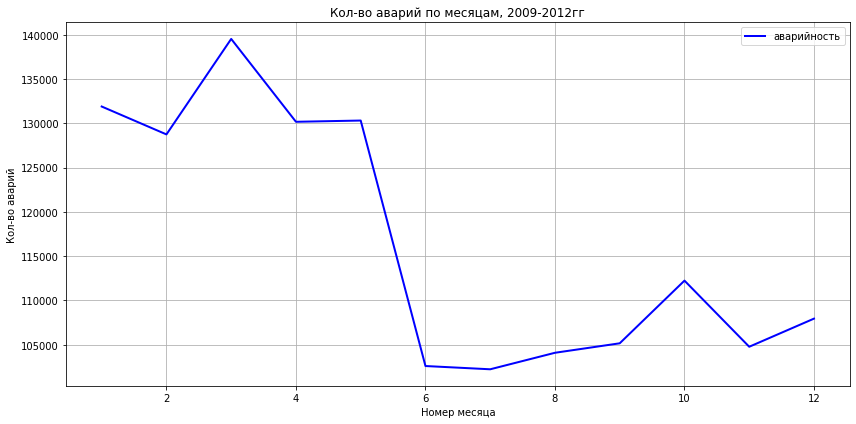

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_accident_per_month1['month_num'], df_accident_per_month1['count_accident'],label='аварийность', color='blue', linewidth=2)

plt.xlabel("Номер месяца")
plt.ylabel("Кол-во аварий")
plt.title("Кол-во аварий по месяцам, 2009-2012гг")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Мы видим, что количество аварий с 1 по 5 месяцы значительно больше (зимне-весенний период), чем с 6 по 12. Пик приходится на 3 месяц (март). Минимальное количество аварий в летнем периоде (6-8 месяцы июнь, июль, август). В октябре количество аварий вновь немного увеличивается

Такую зависиость можно объяснить количеством снега, наледи и осадков на дороге. В зимний период до марта - снег, гололед. В марте снег начинает таять и может идти дождь, дорога становится более скользкой - это объясняет пиковое количество аварий. Резкое уменьшение начиная с мая - дороги становятся сухими. Октябрь - частые дожди, количество аварий снова увеличивется. 

Чтобы убедиться, что это повторяющаяся тенденция, построим совсемщенный график для каждого года

In [16]:
accident_09 = df_accident_per_month.query('month <"2010-01-01"')
accident_09['month_num'] = accident_09['month'].dt.month

accident_10 = df_accident_per_month.query('month <"2011-01-01" and month >="2010-01-01"')
accident_10['month_num'] = accident_10['month'].dt.month

accident_11 = df_accident_per_month.query('month <"2012-01-01" and month >="2011-01-01"')
accident_11['month_num'] = accident_11['month'].dt.month

accident_12 = df_accident_per_month.query('month >="2012-01-01"')
accident_12['month_num'] = accident_12['month'].dt.month

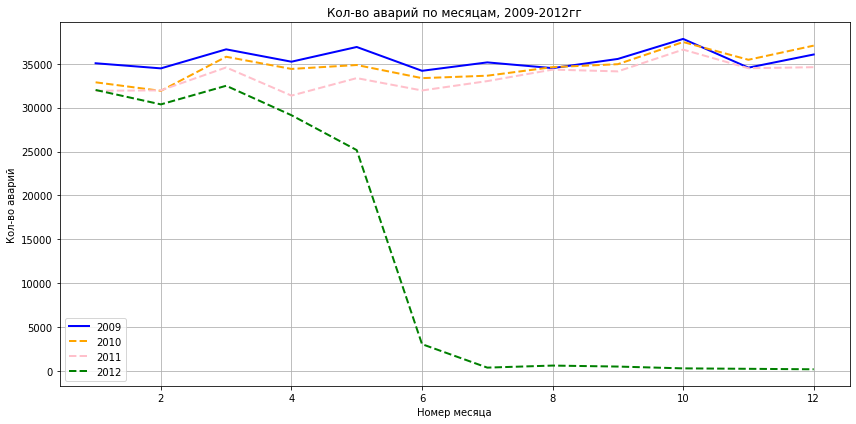

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(accident_09['month_num'], accident_09['count_accident'],label='2009', color='blue', linewidth=2)
plt.plot(accident_10['month_num'], accident_10['count_accident'],label='2010', color='orange',linestyle='--', linewidth=2)
plt.plot(accident_11['month_num'], accident_11['count_accident'],label='2011', color='pink',linestyle='--', linewidth=2)
plt.plot(accident_12['month_num'], accident_12['count_accident'],label='2012', color='green',linestyle='--', linewidth=2)

plt.xlabel("Номер месяца")
plt.ylabel("Кол-во аварий")
plt.title("Кол-во аварий по месяцам, 2009-2012гг")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Оказалось, что суммарная тенденция за весь период немного неправильно отражает картину. Мы видим сильное снижение аварийности на дорогах в 2012 году, начинаяс 6 месяца. Это повляияло на суммарную тенденцию: нам кажется, что начиная с летнего периода на первом (верхнем) графике аварийность значительно меньше, но это не объясняло снижение аварийной ситуации с октября по декабрь (ведь там тоже очень много осадков + первые морозы, снег). 

На самом деле все немного иначе. Мы видим, что в 2012 скорее всего набор данных неполный. Также резкое снижение аварийности на дорогах начиная с мая 2012 можно связать с несколькими факторами:
- **существенное увеличение штрафов за нарушение ПДД** 1 июля 2012 года вступил в силу Федеральный закон № 69-ФЗ (превышение скорости,выезд на встречку,повторное вождение в нетрезвом виде)
- широкое **внедрение камер** автоматической фиксации
- масштабные **кампании по безопасности** дорожного движения (социальная реклама, рейды «пьяный водитель», продвижение использования ремней безопасности и детских кресел)
- обязательная **установка тахографов и ограничителей скорости** на коммерческий транспорт
- повышение правовой культуры водителей (реформы ГИБДД, рост интернет-осведомлённости, появление приложений вроде «Штрафы ГИБДД», обсуждения ПДД в блогах. Водители стали бояться лишиться прав или «попасть на видео»)

Благодаря этим нововведениям количество аварий сократилось почти в сотню раз.

Если отбросить год с новой политикой дорожного движения и рассмотреть период с 2009 по 2011 года то можно заключить, что сезонность хоть и влияла на дорожную ситуацию, но не так сильно,как казалось изначально. И в зимне-весенний период количество аварий было даже чуть ниже, чем в конце осени-начале зимы (возможно водители еще не успели сменить резину и подготовиться к сезону).

Получается что брать данные за 2012 не совсем корректно: да они более новые, но первые пол года аварийная ситуация на дороге до проведения реформ была значительно хуже, чем во вторую половину (или у нас просто неполные данные). Модель может не уловить закономерности. Также не следует брать данные за более ранние года, потому что они не соответствуют действительности и не отражают ситуацию после внедрения новой дрожной политики. По-хорошему нужно собрать свежие данные хотя бы за 2013 год (или один год начиная со второй половины 2012го). Они у нас как будто бы есть (с 01-06-2012 по 01-06-2013), но создается впечатление что за 2013 год даннные недостаточно полные, возможно не все аварии успели учесть и внести в датасет. Поэтому как *рекомендация заканчику*: **для построения более точной модели предоставить полные данные за период 2013 года или позднее**. Эти данные будут отражать соответсвующую действительности ситуацию на дорогах, когда водители привыкли к нововведениям, камерам и новым штрафам за создание аварийной ситуации (например выезд на встречку)

## Постановка задач

Для лучшего понимания данных и выявления важных для модели закономерностей нужно исследовать следующие задачи:

1) Провести анализ **серьёзности повреждений** транспортного средства, исходя из **состояния дороги** в момент ДТП (связать collisions и parties);

2) Найти самые **частые причины ДТП** (таблица parties).

3) Оценить **взаимосвязь серьезности аварии от физического состояния водителя** (таблица collisions, серьёзность происшествия COLLISION_DAMAGE; таблица parties, PARTY_DRUG_PHYSICAL). Как влияет алкогольное опьянение на серьезность аварии (таблица collisions, серьёзность происшествия COLLISION_DAMAGE; таблица parties, PARTY_SOBRIETY)


4) Исследовать **в какое время наблюдается пиковое значение количества аварий**. (таблица collisions, время происшествия COLLISION_TIME). Гипотеза: в час-пик количество аварий значительно увеличивается (утром и вечером когда все едут на/с работы). **В какое время** происходят наиболее **серьезные аварии**?(таблица collisions, время происшествия - COLLISION_TIME; таблица collisions, серьёзность происшествия- COLLISION_DAMAGE).   Гипотеза: предположительно аварии в вечерний час пик в большинстве - царапины по невнимательности. Наиболее серьезные происшествия могут происходит, когда водитель устал или находится в состоянии алкогольного опьянения (преимущественно ночное время). Либо в утренние часы когда люди спешат на работу и опаздывают, что может влиять на превышение скорости.

5) Как **количество аварий  зависит от возраста автомобиля** (таблица Vehicles, VEHICLE_AGE). Посмотреть есть ли взаимосвязь между количеством аварий, возрастом авто и состоянием дорожного покрытия? (таблица Vehicles, VEHICLE_AGE; таблица collisions, ROAD_SURFACE) возможно старые машины хуже справляются с заносами, чаще глохнут и т.д. И оценить взаимосвять количества аварий,  возраста авто и состояния дороги (таблица Vehicles, VEHICLE_AGE; таблица  collisions, Дорожное состояние ROAD_CONDITION_1). Возможно старые авто хуже справляются с непригодными для езды дорогами.

6) Как **погода влияет на аварийность**? Посмотреть количество аварий в зависимости от погоды (таблица collisions, погода WEATHER_1). Какие **виды автомобилей** хуже **справляются с непогодой** а какие лучше (таблица collisions, погода WEATHER_1; таблица Vehicles, тип кузова VEHICLE_TYPE)? предположительно внедорожникам все нипочем, а низкие седаны могут застрять в луже, например когда в мотор попадает вода). **Как старые вато справляются с непогодой**? Разбить возраст авто на три категории (старые,новые, средний), Например построить график зависимости количества аварий от погоды с параметром hue= возраст. Так, например бензиновые машины без защиты двигателя (в которых свечи, катушки зажигания и высоковольтные провода расположены высоко и не защищены) глохнут при попадании влаги — нарушается искрообразование. Автомобили с устаревшими/изношенными системами зажигания (старые карбюраторные или с плохой изоляцией) имеют повышенный риск пробоя и коротких замыканий при попадании воды. 

### Рассмотрим третью и шестую задачи

Мы хотим понять насколько **серьезность аварии зависит от самочувствия водителя**. Для этого разобьем задачу на подзадачи:


1) Оценим взаимосвязь *серьезности аварии от физического состояния водителя* (таблица collisions, серьёзность происшествия COLLISION_DAMAGE; таблица parties, PARTY_DRUG_PHYSICAL).

2) Посмотрим как  влияет *алкогольное опьянение на серьезность аварии* (таблица collisions, серьёзность происшествия COLLISION_DAMAGE; таблица parties, PARTY_SOBRIETY)

В обоих случаях нам понадобятся две таблицы: collisions и parties

1) Сформируем SQL-запрос для первой подзадачи. 
Нам нужно соединить таблицы collisions и parties по case_id таким образом, чтобы все участники происшествия из таблицы parties связанные с этой аварией по case_id вошли в наш запрос. Нас интересуют виновные участники (виновность участника AT_FAULT), и только те аварии где указано физическое состояние участника PARTY_DRUG_PHYSICAL. Для каждой строки аварии добавим оставим описание серьезности (COLLISION_DAMAGE, всего 5 категорий)

Построим график и сделаем вывод по нему

In [18]:
helth_damage = """
SELECT p.case_id,
       p.PARTY_DRUG_PHYSICAL,
       c.COLLISION_DAMAGE
FROM parties AS p
LEFT JOIN collisions AS c ON p.case_id=c.case_id
WHERE p.AT_FAULT>0
      AND PARTY_DRUG_PHYSICAL NOT IN ('None', 'not applicable')
"""

In [19]:
df_helth_damage =pd.read_sql(helth_damage, engine)

In [20]:
df_helth_damage.party_drug_physical.unique()

df_helth_damage

case_id   party_drug_physical collision_damage
0       4014984  under drug influence            fatal
1       4018996                     G    middle damage
2       4036671                     G    middle damage
3       4114743                     G     small damage
4       4114875                     G     small damage
...         ...                   ...              ...
208820  4543779                     G     small damage
208821  4545979                     G     small damage
208822  4546379                     G          scratch
208823  4546590                     G     small damage
208824  4546595                     G     small damage

[208825 rows x 3 columns]

 Категория G - это возможное ухудшение состояния

Under Drug Influence (под воздействием лекарств), Impairment — Physical (ухудшение состояния), G — Impairment Unknown (не известно), Sleepy/Fatigued (Сонный/Усталый)

График интерактивный- можно выделить интересующую область и приблизить, посмотреть точные цифры.

Самая большая категория в физическом состоянии водителей - это возможное ухудшение состояния (т.е. не определено точно, было ухудшение или нет). Во всех случаях бОльшая часть аварий заканчивалась легим уроном, особенно в этой категории (G) - больше 2/3.   
В случае сонного состояния водителей или действительно наступившего физического ухудшения большинство аварий тоже заканчивались с легким уроном или царапинами.

Однако можно отметить, что в столбце с фатальным исходом больше 50% водителей находились под воздействием лекарственных препаратов. В столбце с сильной степенью серьезности аварии водители под воздейситвием лекарств занимают около 13,5%, а со средней - 12%. Таким образом можно заключить, что **прием лекарств значительно увеличивает риск серьезной аварии.**

**Сонное состояние водителя реже**, чем воздействие лекарств, **приводит в сильно негативным последствиям**: большинство аварий с участием сонного водителя оборачиваются маленькими повреждениями или царапинами, реже средними. Серьезные повреждения и фатальные случаи крайне редки

2) Сформируем SQL-запрос для второй подзадачи. Посмотрим как  влияет *алкогольное опьянение на серьезность аварии*. 
Для этого нам потребуются виновные (AT_FAULT) участники ДТП из таблицы parties находящиеся в состоянии алкогольного опьянения (PARTY_SOBRIETY). Мы будем делать LEFT JOIN по case_id, т.к. виновников ДТП может быть несколько (столкнулись 2 или 3 машины на перестке,виновать оба водителя и т.д. и вдруг окажется что все были под алкоголем). Будем присоединять таблицу collisions ( серьёзность происшествия COLLISION_DAMAGE) к таблице parties потому что нам надо чтобы повторяющиеся case_id остались в случае если виновников несколько

FROM parties AS p
LEFT JOIN collisions AS c ON p.case_id = c.case_id


Запрос получился похожим на предыдущий. Также не учитываем пустые строки и те случаи,где оценка не проводилась.

In [21]:
alcohol_damage = """
SELECT p.case_id,
       p.PARTY_SOBRIETY,
       c.COLLISION_DAMAGE
FROM parties AS p
LEFT JOIN collisions AS c ON p.case_id=c.case_id
WHERE p.AT_FAULT>0
      AND PARTY_SOBRIETY NOT IN ('None', 'not applicable', 'impairment unknown')
"""

In [22]:
df_alcohol_damage =pd.read_sql(alcohol_damage, engine)

In [23]:
df_alcohol_damage

case_id                      party_sobriety collision_damage
0        3982918               had not been drinking          scratch
1        4014984               had not been drinking            fatal
2        4021529  had been drinking, under influence     small damage
3        4027566               had not been drinking          scratch
4        4027576               had not been drinking    middle damage
...          ...                                 ...              ...
1063757  5456481  had been drinking, under influence          scratch
1063758  5456544               had not been drinking     small damage
1063759  5456579               had not been drinking    severe damage
1063760  5456610               had not been drinking     small damage
1063761  5456619               had not been drinking    middle damage

[1063762 rows x 3 columns]

In [24]:
df_alcohol_damage.party_sobriety.unique()

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence'], dtype=object)

Мы видим, что в боольшинстве случаев водители были трезвыми. Однако в случае фатальной аварии или сильного повреждений автомобиля доля пьяных водителей намного больше. Можно заключить, что **алкоголь может значительно увеличить риск серьезной аварии**

Наши выводы соответсвуют действительности: вождение в состоянии алкогольного опьянения или под воздействием некоторых лекарств запрещено. Однако, возможно, для нашей каршеринговой компании это не самое полезное исследоавние. Ведь нас интересует предсказание риска аварии на дороге. Подразумевается, что водитель, берущий авто в прокат, соотвествует всем законодательным нормам, и не принимал никаких запрешенных веществ. В конкретном случае нашей модели эти признаки могут быть избыточными. Ведь наша цель оценить уровень риска аварии в соответствии с выбранным маршрутом.

**Рекомендации**: *полезно еще раз напомнить об этих правилах клиентам перед бронированием поездки. Можно сделать всплывающее окно-предупреждение или перед каждой поездкой требовать соглашение, что водитель находится в хорошем физическом состоянии. Или пройти небольшой медицинский опросник, который поможет оценить самочувствие водителя и психо-эмоциональное состояние (что тоже может влиять на качество вождения).*

Действительно полезным фактором для нашей модели может оказаться **оценка погодных условий**. Разберем нашу **шестую задачу** в качестве примера

**Как погода влияет на аварийность?**
- Посмотреть количество аварий в зависимости от погоды (таблица collisions, погода WEATHER_1) и оценить серьезность

- Какие виды автомобилей хуже справляются с непогодой а какие лучше (таблица collisions, погода WEATHER_1; таблица Vehicles, тип кузова VEHICLE_TYPE)? 

- Как старые авто справляются с непогодой? Разбить возраст авто на три категории (старые,новые, средний), Например построить график зависимости количества аварий от погоды с параметром hue= возраст. Так, например бензиновые машины без защиты двигателя (в которых свечи, катушки зажигания и высоковольтные провода расположены высоко и не защищены) глохнут при попадании влаги — нарушается искрообразование. Автомобили с устаревшими/изношенными системами зажигания (старые карбюраторные или с плохой изоляцией) имеют повышенный риск пробоя и коротких замыканий при попадании воды.


In [25]:
weather = """
SELECT case_id,
       weather_1,
       collision_damage
FROM collisions
WHERE  weather_1 IS NOT NULL
"""

In [26]:
df_weather =pd.read_sql(weather, engine)

In [27]:
df_weather.weather_1.unique()

array(['cloudy', 'clear', 'raining', 'fog', 'snowing', 'other', 'wind'],
      dtype=object)

In [28]:
df_special_weather = df_weather.query('weather_1 in ["raining","fog","snowing","other","wind"]')

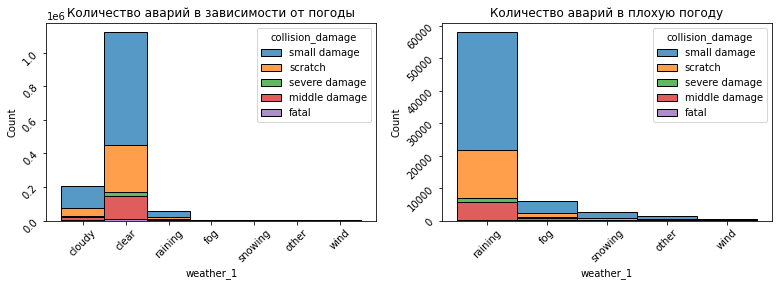

In [29]:
plt.figure(figsize=(13,8))
plt.subplot(2, 2, 1)
sns.histplot(data=df_weather, x='weather_1',hue='collision_damage',multiple= "stack")
plt.title('Количество аварий в зависимости от погоды')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

plt.subplot(2, 2, 2)
sns.histplot(data=df_special_weather, x='weather_1',hue='collision_damage',multiple= "stack")
plt.title('Количество аварий в плохую погоду')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

Изначально кажется, что большинство аварий происходят в ясную погоду. Скорее всего потому что такая погода бывает чаще
Туман,снегопад и сильный ветер происходят реже чем обычная ясная или облачная погода

Посмотрим процент значимых аварий ("fatal","severe damage", "middle damage") при различных погодных условиях:

In [30]:
seriosly_damage = df_weather.query('collision_damage in ["fatal","severe damage", "middle damage"]')

In [31]:
round((seriosly_damage.weather_1.value_counts()/df_weather.weather_1.value_counts())*100,2).sort_values(ascending=False)

fog        16.83
clear      15.27
wind       14.86
cloudy     13.62
raining    11.77
other      11.28
snowing    11.24
Name: weather_1, dtype: float64

Процент серьезных аварий в ясную погоду по-прежнему высок. Мы видим, что из погодных условий туман сильнее может увеличивать риск серьезных аварий

**Какие авто хуже справляются с непогодой?**

In [32]:
weather_vehicle = """
SELECT v.case_id,
       v.vehicle_type,
       c.weather_1
FROM vehicles AS v
LEFT JOIN collisions AS c ON v.case_id=c.case_id
WHERE  c.weather_1 IS NOT NULL
"""

In [33]:
df_weather_vehicle  =pd.read_sql(weather_vehicle, engine)

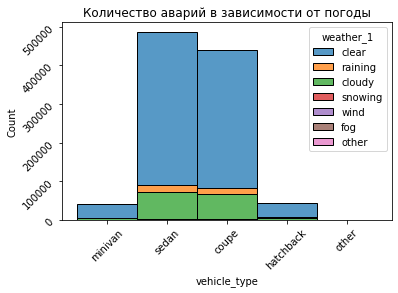

In [34]:
plt.figure(figsize=(13,8))
plt.subplot(2, 2, 1)
sns.histplot(data=df_weather_vehicle, x='vehicle_type',hue='weather_1',multiple= "stack")
plt.title('Количество аварий в зависимости от погоды')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

так мало что понятно

In [35]:
pivot = df_weather_vehicle.pivot_table(
    index='vehicle_type',
    columns='weather_1',
    values='case_id',    
    aggfunc='count',
    fill_value=0
)
pivot['total'] = pivot.sum(axis=1)

bad_weather = ['raining', 'snowing', 'fog', 'wind', 'other']
pivot['bad_weather'] = pivot[bad_weather].sum(axis=1)  #посчитаем сумму аварий в полохую погоду
pivot['bad_weather_share'] = round((pivot['bad_weather'] / pivot['total']) * 100,2) #процент аварий в плохую погоду

pivot = pivot.sort_values('bad_weather_share', ascending=False)

In [36]:
pivot

weather_1      clear  cloudy   fog  other  raining  snowing  wind   total  \
vehicle_type                                                                
hatchback      37949    4977   146     57     2111       59    17   45316   
coupe         356408   64436  2039    308    16946      483   137  440757   
sedan         395279   69811  1538    268    18276     1264   135  486571   
other            992     138     4      0       43        5     0    1182   
minivan        37591    4332    82     39      692        2     8   42746   

weather_1     bad_weather  bad_weather_share  
vehicle_type                                  
hatchback            2390               5.27  
coupe               19913               4.52  
sedan               21481               4.41  
other                  52               4.40  
minivan               823               1.93

Чем выше процент аварий в непогоду- тем хуже тип авто справляется. Мы видим, что **хетчбэкам сложнее**, чем другим автомобилям дается преодоление погодных условий.**Лучше всего справляются минивэны**

In [37]:
weather_age = """
SELECT v.case_id,
       v.vehicle_age,
       c.weather_1
FROM vehicles AS v
LEFT JOIN collisions AS c ON v.case_id=c.case_id
WHERE  c.weather_1 IS NOT NULL
       AND v.vehicle_age IS NOT NULL
"""

In [38]:
df_weather_age = pd.read_sql(weather_age, engine)

In [39]:
df_weather_age.vehicle_age.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20, 161])

In [40]:
strange = df_weather_age.query('vehicle_age==161')
strange

case_id  vehicle_age weather_1
90227   4660667          161     clear
106101  5542342          161     clear
221311  4898062          161    cloudy
249323  5403332          161     clear
345846  5639033          161     clear
410668  4302016          161     clear
417209  4990375          161     clear
464031  5158413          161    cloudy
490608  4015202          161    cloudy
622666  4180401          161     clear
646402  4302172          161     clear
646781  4391777          161    cloudy
734555  5189844          161     clear
758560  4302067          161     clear
817775  4898149          161     clear
836438  4990167          161    cloudy
961013  5291247          161     clear

161 это скорее всего выброс, хотя таких строк 11

In [41]:
df_weather_age.drop(index=strange.index, inplace=True)

Разделим возраст авто на три категории опиратясь на жизненный цикл автомобилей:

*Новые*: 0–3 года — обычно авто на гарантии.

*Средние*: 4–10 лет — активное использование, но уже без гарантии.

*Старые*: 11–20 лет — машины уже "в возрасте", чаще встречаются поломки и хуже безопасность.

In [42]:
age_conditions = [
    df_weather_age['vehicle_age'] < 4,
    df_weather_age['vehicle_age'] <8,
    df_weather_age['vehicle_age'] >= 8
]
age_types = ['новый', 'средний', 'старый']
df_weather_age['age_types'] = np.select(age_conditions, age_types, 'другой')

In [43]:
df_weather_age

case_id  vehicle_age weather_1 age_types
0       4091920           11     clear    старый
1       5305282            1     clear     новый
2       5305300            6     clear   средний
3       5366604            7     clear   средний
4       4113617            2   raining     новый
...         ...          ...       ...       ...
992114  5304688            2     clear     новый
992115  5304704            4     clear   средний
992116  5304831            4     clear   средний
992117  5304880            2    cloudy     новый
992118  5304939            5     clear   средний

[992102 rows x 4 columns]

In [44]:
df_weather_age.age_types.value_counts()

средний    397362
новый      364942
старый     229798
Name: age_types, dtype: int64

Наши выборки не равны, это можно объяснить тем, что на дороге чаще встречаются более новые машины, на старых ездит меньше людей. 

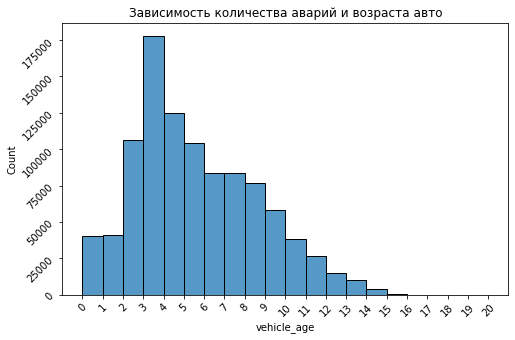

In [45]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_weather_age, x='vehicle_age', binwidth=1, edgecolor='black')
plt.title('Зависимость количества аварий и возраста авто')
plt.yticks(rotation=45)
plt.xticks(ticks=range(0, 21), rotation=45);

В основном в аварии попадают авто от 2-6 лет. 

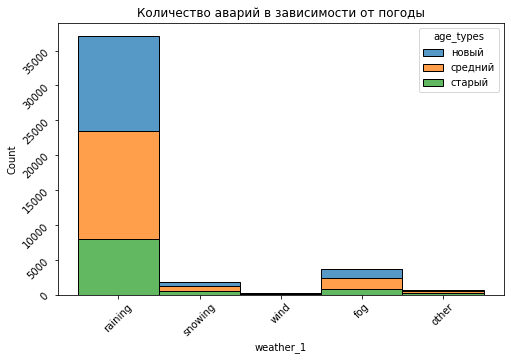

In [46]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_weather_age.query('weather_1 not in ["clear","cloudy"]'), x='weather_1',hue='age_types',multiple= "stack")
plt.title('Количество аварий в зависимости от погоды')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

Такой график нам тоже не дает ясности, потому что изначально количество авто в категориях разное. Посчитаем процент в категориях

In [47]:
pivot2 = df_weather_age.pivot_table(
    index='age_types',
    columns='weather_1',
    values='case_id',    
    aggfunc='count',
    fill_value=0
)
pivot2['total'] = pivot2.sum(axis=1)

bad_weather = ['raining', 'snowing', 'fog', 'wind', 'other']
pivot2['bad_weather'] = pivot2[bad_weather].sum(axis=1)  #посчитаем сумму аварий в полохую погоду
pivot2['bad_weather_share'] = round((pivot2['bad_weather'] / pivot2['total']) * 100,2) #процент аварий в плохую погоду

pivot2 = pivot2.sort_values('bad_weather_share', ascending=False)

In [48]:
pivot2 

weather_1   clear  cloudy   fog  other  raining  snowing  wind   total  \
age_types                                                                
средний    321894   57239  1597    277    15437      797   121  397362   
новый      297916   51166  1351    217    13667      529    96  364942   
старый     188171   32123   783    164     8027      457    73  229798   

weather_1  bad_weather  bad_weather_share  
age_types                                  
средний          18229               4.59  
новый            15860               4.35  
старый            9504               4.14

**Результаты удивили: в процентном соотношении старые авто справляются с плохими погодными условиями не хуже (а даже незначительно лучше, чем более новые машины)**. Возможно возраст авто не очень важный признак, чтобы  надо посмотреть как старые авто справляются с плохим дорожным покрытием и т.д. для того, чтобы определить важность признака

## Собираем наш датасет

Определим признаки которые нам точно не нужны в датасете для прогнозирования риска ДТП для каршеринговой компании и которые могут быть полезными. Для прогнозирования вероятности ДТП мы не можем использовать признаки, описывающие уже свершившуюся аварию.

**не берем:**

    **collisions**
    case_id 
    collision_damage,
    primary_coll_factor
    party_count
    pcf_violation_category
    type_of_collision
    motor_vehicle_involved_with
    
    **parties**
    party_number не берем но объединяем
    party_type не берем, потому что мы по нему фильтруем (и он состоит из одного признака)
    party_drug_physical не берем, потому что сложно определить состояние 
    party_sobriety
    
    **vehicles**
    case_id
    patry_number

**Берем:**

    **collisions**
    collision date,  но месяц лучше не брать потому что год не полный лучше взять день недели категриальные данные
    collision_time лучше брать час, а не разбивать на категории утро-день-ночь категориальные данные
    intersection посчитать кол-во перекрестков?
    weather_1 можно категоризировать
    road_surface можно категоризировать на плохую, хорошую
    lighting 
    county_city_location
    county_location
    direction
    distance
    location_type
    road_condition_1
    
    **parties**
    p.at_fault - наш таргет
    p.insurance_premium
    p.cellphone_in_use
    
    **vehicles**
    v.vehicle_type
    v.vehicle_transmission
    v.vehicle_age  #можно ограничить не старше 10 лет, потому что в каршеринге старые авто не используются

Сформируем запрос, удовлетворяющий нашим условиям:

в нашем запросе мы прописываем условия:

1) нам нужны все три таблицы. Т.к. данных достаточно много, мы возьмем только те строки, в которых есть данные из всех таблиц (будем присоединять через INNER JOIN)

2) Выбираем тип участника - только машина (Parties: PARTY_TYPE = 'car')

3) Берем только существенные аварии, исключаем случаи царапины (c.collision_damage != 'scratch')

4) Берем самые свежие данные за 2012 год (c.collision_date=2012)

5) т.к. у нас каршеринговая компания и машины в ней не должны быть старыми, выгрузим только те данные, в которых возраст авто не более 10 лет (v.vehicle_age <=10)

6) из даты аварии сразу выгрузим день недели. Месяц лучше не брать, т.к. данные за год неполные

In [49]:
general_query  = """
SELECT EXTRACT(DOW FROM c.collision_date::date) AS weekday_collision,
       EXTRACT(HOUR FROM c.collision_time::time) AS hour_collision,
       c.intersection,
       c.weather_1,
       c.road_surface,
       c.lighting,
       c.county_city_location,
       c.county_location,
       c.direction,
       c.distance,
       c.location_type,
       c.road_condition_1,
       p.at_fault,
       p.insurance_premium,
       p.cellphone_in_use,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age

FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id=v.case_id AND p.party_number=v.party_number
INNER JOIN collisions AS c ON p.case_id=c.case_id

WHERE p.party_type='car'
      AND EXTRACT (YEAR FROM c.collision_date::date)=2012
      AND c.collision_damage != 'scratch'
      AND v.vehicle_age<=10
"""   
    

In [50]:
df_general_query = pd.read_sql(general_query, engine)

## Предобработка датасета

In [51]:
df_general_query.head(2)

weekday_collision  hour_collision  intersection weather_1 road_surface  \
0                0.0            17.0           0.0     clear          dry   
1                2.0             0.0           0.0     clear          dry   

                     lighting county_city_location county_location direction  \
0                    daylight                 1942     los angeles     south   
1  dark with no street lights                 4100       san mateo      east   

   distance location_type road_condition_1  at_fault  insurance_premium  \
0      20.0          None           normal         0               46.0   
1      40.0  intersection            other         1               38.0   

   cellphone_in_use vehicle_type vehicle_transmission  vehicle_age  
0               0.0        sedan                 auto            2  
1               0.0        sedan                 auto            5

Все столбцы выгрузились, названия в порядке(нижний регистр, snake_case).

In [52]:
df_general_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51413 entries, 0 to 51412
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weekday_collision     51413 non-null  float64
 1   hour_collision        51333 non-null  float64
 2   intersection          51256 non-null  float64
 3   weather_1             51258 non-null  object 
 4   road_surface          51107 non-null  object 
 5   lighting              51267 non-null  object 
 6   county_city_location  51413 non-null  object 
 7   county_location       51413 non-null  object 
 8   direction             39866 non-null  object 
 9   distance              51413 non-null  float64
 10  location_type         24139 non-null  object 
 11  road_condition_1      51191 non-null  object 
 12  at_fault              51413 non-null  int64  
 13  insurance_premium     51002 non-null  float64
 14  cellphone_in_use      47485 non-null  float64
 15  vehicle_type       

51 тыс строк, датасет не очень большой, но достаточный для обучения модели. Есть пропуски, формат некоторых столбцов нужно изменить. Но сначала разберемся с пропусками

### Дубликаты

In [53]:
duplicate_index = df_general_query[df_general_query.duplicated()].index

Полные дубликаты есть,удалим их

In [54]:
df_general_query.drop(index=duplicate_index, inplace=True)

### Пропуски:

In [55]:
df_general_query.isna().sum().sort_values(ascending=False)

location_type           27250
direction               11534
cellphone_in_use         3923
vehicle_transmission      535
insurance_premium         410
road_surface              306
road_condition_1          221
intersection              157
weather_1                 155
lighting                  146
hour_collision             80
weekday_collision           0
vehicle_type                0
distance                    0
at_fault                    0
county_location             0
county_city_location        0
vehicle_age                 0
dtype: int64

In [56]:
df_general_query.isna().mean().sort_values(ascending=False).head(12) * 100

location_type           53.039298
direction               22.449734
cellphone_in_use         7.635712
vehicle_transmission     1.041322
insurance_premium        0.798022
road_surface             0.595597
road_condition_1         0.430154
intersection             0.305584
weather_1                0.301691
lighting                 0.284174
hour_collision           0.155712
weekday_collision        0.000000
dtype: float64

location_type мог бы быть важным признаком, но в нем более 50% пропусков,еоторые сложно восстановить. Удалим этот признак

In [57]:
df_general_query.drop(columns='location_type', inplace=True)

In [58]:
df_general_query.direction.unique()

array(['south', 'east', 'north', 'west', None], dtype=object)

В признаке direction тоже довольно много пропусков, которые сложно заполнить логически. Можем заполнить их значением-заглушкой unknown

Рассмотрим признак cellphone_in_use

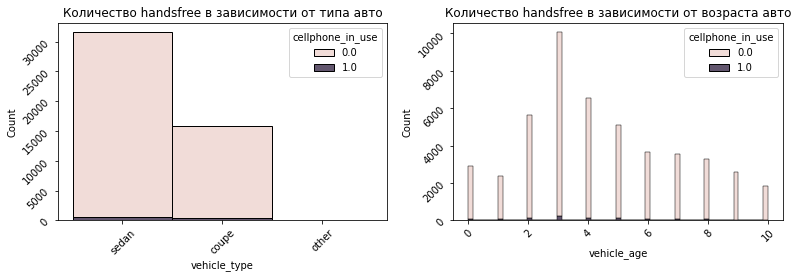

In [59]:
plt.figure(figsize=(13,8))
plt.subplot(2, 2, 1)
sns.histplot(data=df_general_query, x='vehicle_type',hue='cellphone_in_use',multiple= "stack")
plt.title('Количество handsfree в зависимости от типа авто')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

plt.subplot(2, 2, 2)
sns.histplot(data=df_general_query, x='vehicle_age',hue='cellphone_in_use',multiple= "stack")
plt.title('Количество handsfree в зависимости от возраста авто')
plt.yticks(rotation=45)
plt.xticks(rotation=45);

Краткий анализ показал, что почти у всех машин отсутствует handsfree. Ни по году,ни по типу кузова ни рл стоимости страховки определить наличие возможности разговаривать по громкой связи определить нельзя (на графиках не обнаружилось завиимоти). Лучше заполним заглушкой unknown, потому что в признаке большой дисбаланс и если мы заполним наиболее частным в большинстве случаев это будет верно, но мы потеряем редкий класс. и если признак окажется сильным, то наша модель не обучится должным образом

Т.к. дальше мы заполняем пропуски по группам. разделим наш дасет на обучающую и тестовую выборки (во избежание утечки). И заполнять пропуски будем по-отдельности

In [60]:
# Разделяем на X и y
X = df_general_query.drop(columns=['at_fault'], axis=1)  
y = df_general_query['at_fault'] 

# Разделяем на тренировочную и валидационную выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

Для восстановления пропусков и дальнейшей работы соберем полный обучающий **df_general_query** и тестовый **df_general_query_test** датасеты: 

In [61]:
df_general_query = pd.concat([X_train,y_train], axis=1)
df_general_query_test = pd.concat([X_test,y_test], axis=1)

Сделаем копию датасета, чтобы потом посчитать процент удаленных данных

In [62]:
df_general_query1 = df_general_query.copy()

Пропуски в направлениях и handsfree мы не можем восстановить логически, поэтому заполним значением-заглушкой

In [63]:
df_general_query['direction'] = df_general_query['direction'].fillna('unknown')
df_general_query['cellphone_in_use'] = df_general_query['cellphone_in_use'].fillna('unknown')

df_general_query_test['direction'] = df_general_query_test['direction'].fillna('unknown')
df_general_query_test['cellphone_in_use'] = df_general_query_test['cellphone_in_use'].fillna('unknown')

vehicle_transmission заполним наиболее частым в соответствии с типом кузова и возрастом машины.

In [64]:
df_general_query["vehicle_transmission"] = (
df_general_query.groupby(["vehicle_type","vehicle_age"])["vehicle_transmission"].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x))

df_general_query_test["vehicle_transmission"] = (
df_general_query_test.groupby(["vehicle_type","vehicle_age"])["vehicle_transmission"].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x))

пропусков в hour_collision мало, просто удалим эти строки

In [65]:
df_general_query.dropna(subset=['hour_collision'], inplace=True )

df_general_query_test.dropna(subset=['hour_collision'], inplace=True )

освещение lighting зависит от hour_collision. сгруппируем, заполним первым значением в соответствии с группой.Это сработает не всегда(где-то могут быть установлены фонари, а где-то нет), но у нас мало пропусков и в большинстве случаев это будет верно.

In [66]:
df_general_query["lighting"] = df_general_query.groupby("hour_collision")["lighting"].transform(
    lambda x: x.fillna(x.dropna().iloc[0]) if x.notna().any() else x.fillna("unknown"))

df_general_query_test["lighting"] = df_general_query_test.groupby("hour_collision")["lighting"].transform(
    lambda x: x.fillna(x.dropna().iloc[0]) if x.notna().any() else x.fillna("unknown"))

road_surface зависит от weather_1. заполним наиболее частым по группам

In [67]:
df_general_query["road_surface"] = (
df_general_query.groupby("weather_1", dropna=False)["road_surface"].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x))

df_general_query_test["road_surface"] = (
df_general_query_test.groupby("weather_1", dropna=False)["road_surface"].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x))

т.к. пропусков в weather_1 меньше чем пол процента, мы могли бы их также заполнить other как значением-заглушкой или удалить. Удалим, чтобы не увеличивать неопределенность

также мы не можем восстановить пропуски в intersection и road_condition_1. Удалим эти строки

In [68]:
df_general_query.dropna(subset=['weather_1','intersection', 'road_condition_1'], inplace=True )

df_general_query_test.dropna(subset=['weather_1','intersection', 'road_condition_1'], inplace=True )

insurance_premium заполним медианным значением

In [69]:
df_general_query.insurance_premium.fillna(df_general_query['insurance_premium'].median(),inplace=True)

df_general_query_test.insurance_premium.fillna(df_general_query_test['insurance_premium'].median(),inplace=True)

Посчитаем сколько удалили:

In [70]:
((df_general_query1.shape[0]-df_general_query.shape[0])/df_general_query1.shape[0])*100

1.0705447265244834

Удалили чуть больше 1%, допустимо. Поправим тип данных, где можно

In [71]:
df_general_query['weekday_collision'] = df_general_query['weekday_collision'].astype(int)
df_general_query['hour_collision'] = df_general_query['hour_collision'].astype(int)
df_general_query['distance'] = df_general_query['distance'].astype(int)
df_general_query['intersection'] = df_general_query['intersection'].astype(int)
df_general_query['county_city_location'] = df_general_query['county_city_location'].astype(int)

df_general_query_test['weekday_collision'] = df_general_query_test['weekday_collision'].astype(int)
df_general_query_test['hour_collision'] = df_general_query_test['hour_collision'].astype(int)
df_general_query_test['distance'] = df_general_query_test['distance'].astype(int)
df_general_query_test['intersection'] = df_general_query_test['intersection'].astype(int)
df_general_query_test['county_city_location'] = df_general_query_test['county_city_location'].astype(int)

In [72]:
df_general_query.head(2)

weekday_collision  hour_collision  intersection weather_1 road_surface  \
32712                  5              23             1     clear          dry   
36145                  6              20             1     clear          dry   

                      lighting  county_city_location county_location  \
32712  dark with street lights                  1942     los angeles   
36145                 daylight                  5604         ventura   

      direction  distance road_condition_1  insurance_premium  \
32712   unknown         0           normal               20.0   
36145   unknown         0           normal               39.0   

      cellphone_in_use vehicle_type vehicle_transmission  vehicle_age  \
32712              0.0        sedan               manual            4   
36145              0.0        coupe                 auto            5   

       at_fault  
32712         1  
36145         0

In [73]:
df_general_query.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35578 entries, 32712 to 15801
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weekday_collision     35578 non-null  int64  
 1   hour_collision        35578 non-null  int64  
 2   intersection          35578 non-null  int64  
 3   weather_1             35578 non-null  object 
 4   road_surface          35578 non-null  object 
 5   lighting              35578 non-null  object 
 6   county_city_location  35578 non-null  int64  
 7   county_location       35578 non-null  object 
 8   direction             35578 non-null  object 
 9   distance              35578 non-null  int64  
 10  road_condition_1      35578 non-null  object 
 11  insurance_premium     35578 non-null  float64
 12  cellphone_in_use      35578 non-null  object 
 13  vehicle_type          35578 non-null  object 
 14  vehicle_transmission  35578 non-null  object 
 15  vehicle_age    

### Проверим опечатки и разночтения

In [74]:
cat = df_general_query.select_dtypes(include=['object'])
cat

weather_1 road_surface                 lighting county_location  \
32712     clear          dry  dark with street lights     los angeles   
36145     clear          dry                 daylight         ventura   
43       cloudy          dry                 daylight         alameda   
47039     clear          dry                 daylight       riverside   
28840     clear          dry                 daylight     los angeles   
...         ...          ...                      ...             ...   
11287    cloudy          dry                 daylight  san bernardino   
44760     clear          dry                 daylight     los angeles   
38178     clear          dry                 daylight            kern   
860       clear          dry  dark with street lights       riverside   
15801     clear          dry                 daylight     los angeles   

      direction road_condition_1 cellphone_in_use vehicle_type  \
32712   unknown           normal              0.0        sedan   
36145   unknown           normal              0.0        coupe   
43      unknown           normal              0.0        sedan   
47039     north           normal              0.0        coupe   
28840      east           normal              0.0        coupe   
...         ...              ...              ...          ...   
11287     south           normal              0.0        sedan   
44760   unknown           normal              0.0        sedan   
38178      east           normal              0.0        sedan   
860     unknown           normal              0.0        sedan   
15801     north           normal              0.0        coupe   

      vehicle_transmission  
32712               manual  
36145                 auto  
43                  manual  
47039               manual  
28840                 auto  
...                    ...  
11287                 auto  
44760               manual  
38178               manual  
860                 manual  
15801                 auto  

[35578 rows x 9 columns]

In [75]:
cat.columns

Index(['weather_1', 'road_surface', 'lighting', 'county_location', 'direction',
       'road_condition_1', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission'],
      dtype='object')

In [76]:
for col in cat.columns:
    print(col, df_general_query[col].unique())
    print()

weather_1 ['clear' 'cloudy' 'raining' 'snowing' 'fog' 'other' 'wind']

road_surface ['dry' 'wet' 'snowy' 'slippery']

lighting ['dark with street lights' 'daylight' 'dusk or dawn'
 'dark with no street lights' 'dark with street lights not functioning']

county_location ['los angeles' 'ventura' 'alameda' 'riverside' 'butte' 'orange'
 'santa clara' 'kern' 'tulare' 'san mateo' 'mendocino' 'marin'
 'santa barbara' 'monterey' 'san diego' 'sacramento' 'plumas'
 'san bernardino' 'san joaquin' 'lake' 'merced' 'solano' 'placer'
 'san luis obispo' 'contra costa' 'madera' 'fresno' 'shasta' 'stanislaus'
 'tehama' 'kings' 'humboldt' 'napa' 'calaveras' 'mariposa' 'sonoma'
 'siskiyou' 'inyo' 'yolo' 'santa cruz' 'san francisco' 'san benito'
 'el dorado' 'sutter' 'nevada' 'imperial' 'lassen' 'yuba' 'del norte'
 'tuolumne' 'mono' 'glenn' 'sierra' 'colusa' 'amador' 'modoc' 'alpine'
 'trinity']

direction ['unknown' 'north' 'east' 'south' 'west']

road_condition_1 ['normal' 'other' 'construction' 'obstruc

опечаток нет

## EDA

**Описательная статистика числовых признаков**

In [77]:
df_general_query.describe().T

count         mean          std    min     25%  \
weekday_collision     35578.0     3.151442     2.055461    0.0     1.0   
hour_collision        35578.0    13.289926     5.620651    0.0    10.0   
intersection          35578.0     0.214177     0.410256    0.0     0.0   
county_city_location  35578.0  2841.167351  1301.025714  100.0  1942.0   
distance              35578.0   886.036539  8821.283511    0.0    10.0   
insurance_premium     35578.0    35.624403    14.237806    0.0    23.0   
vehicle_age           35578.0     4.409073     2.601642    0.0     3.0   
at_fault              35578.0     0.505453     0.499977    0.0     0.0   

                         50%     75%        max  
weekday_collision        3.0     5.0        6.0  
hour_collision          14.0    17.0       23.0  
intersection             0.0     0.0        1.0  
county_city_location  3009.0  3701.0     5802.0  
distance               146.0   599.5  1584000.0  
insurance_premium       33.0    46.0      105.0  
vehicle_age              4.0     6.0       10.0  
at_fault                 1.0     1.0        1.0

*weekday_collision* дни недели от 0(вскр) до 6(сб), медиана на 3 дне (среда)

*hour_collision* часы аварии 0-23. Медиана в 14 (2 часа дня)

*intersection* большинство значений - не перекресток

*county_city_location* индексы. проверить индекс 100 м.б. выброс

*distance* - расстояние от главной дороги(метры). 0 означает, что авария произошла на главной дороге. 1584000 максимальное значение похоже на выброс

*at_fault* либо виновен,либо не виновен. Классы распределены почти поровну

*insurance_premium* размер страховки. Кто-то без страховки, у кого-то очень дорогая. 105 тыс доларов это реальное число для 
страховки?

*vehicle_age* мы уже убрали выбросы при выгрузке данных.

Построим графики 

In [78]:
df_general_query_num = df_general_query.select_dtypes(include='number').columns.tolist()
df_general_query_num

['weekday_collision',
 'hour_collision',
 'intersection',
 'county_city_location',
 'distance',
 'insurance_premium',
 'vehicle_age',
 'at_fault']

In [79]:
def graf(data):
    for features in df_general_query[df_general_query_num]:

        plt.figure(figsize=(13,8))
        plt.subplot(2, 2, 1)
        sns.histplot(data=data, x=features, hue='vehicle_type',multiple= "stack", bins=27)
        plt.title(features)
        plt.yticks(rotation=45)
        plt.xticks(rotation=45);

        plt.subplot(2, 2, 2)
        data[[features]].boxplot(vert=False);
        plt.xticks(rotation=45)
        plt.yticks(rotation=45);
        plt.title('диаграмма размаха')
        plt.show();

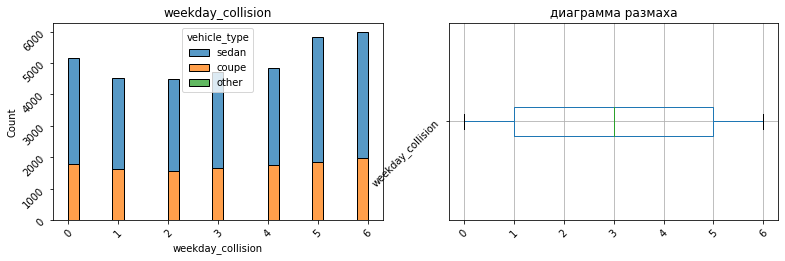

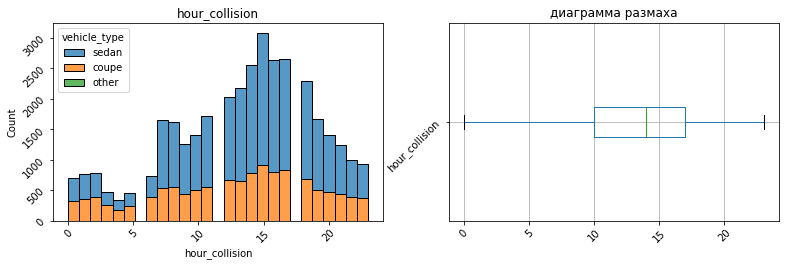

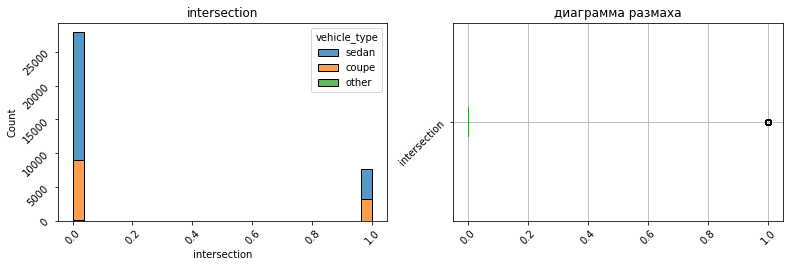

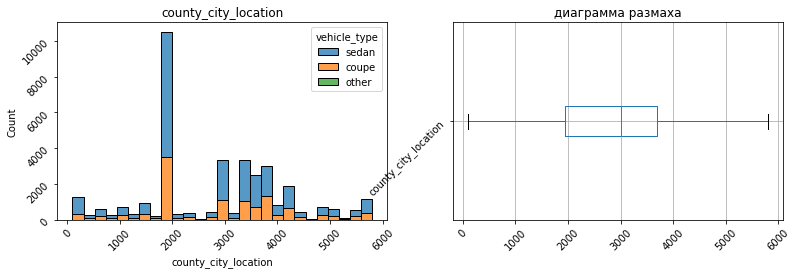

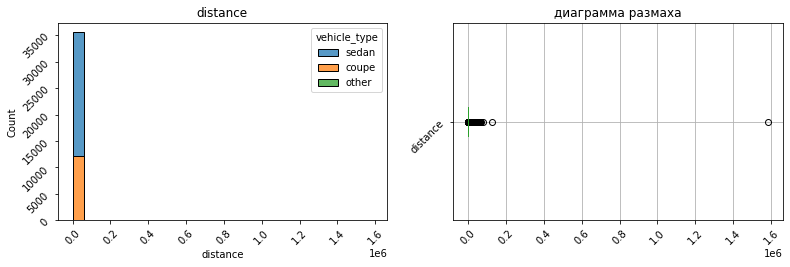

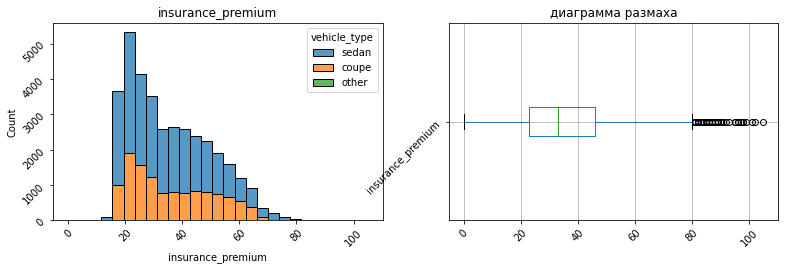

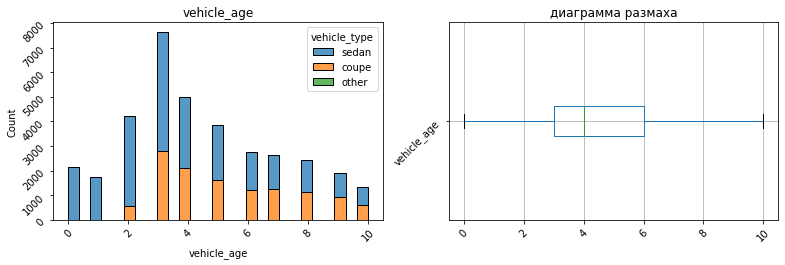

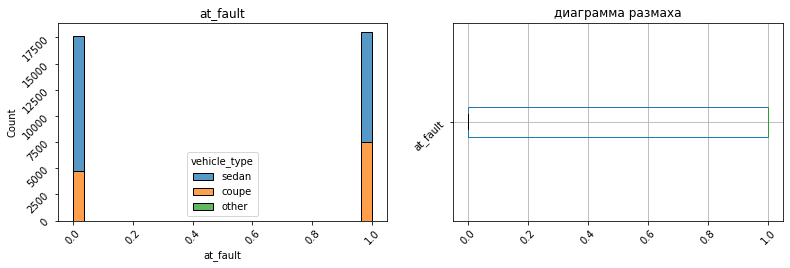

In [80]:
graf(df_general_query)

Построили графики всех числовых признаков (intersection и at_fault бинарный признаки, скорее его можно отнести к категориальному, но графики и описательную статистику все равно удобно строить). Добавили разделение по типу машины (просто потому что можем), но никаких красивых зависимостей это разделение нам не дало. Во всех признаках тип машин распределен более-менее равномерно, с учетом того что седаны встречаются чаще чем couple, а значение other практически не попадается. Нужно посмотреть как много other в vehicle_type, если единицы может быть стоит убрать. 

Перекрестки действительно встречаются значительно реже чем обычная дорога. Максимальное значение дистанции -выброс. Распределение страховки смещено влево и имеет длинный хвост справа. Стоит оценить значения страховки после 80 тыс, может это выброс. 

мы видим что самые новые машины (возраст 0 и 1 год) исключительно седаны. Большая часть авто возраста 3 лет

Удалим выбросы:

Оставим дистанцию не более 60 км (это примерно междугородняя поездка или из одного конца мегаполиса в другой)

In [81]:
df_general_query = df_general_query.query('distance<70000')

df_general_query_test = df_general_query_test.query('distance<70000')

In [82]:
fig_salary = px.histogram(
    df_general_query,
    x='insurance_premium',
    nbins=85,
    marginal='box',
    title='Распределение суммы страховки',
    labels={'insurance_premium':'сумма страховки'})

fig_salary.show()

В наших цифрах (тысячи долларов)insurance_premium- это скорее сумма страхового покрытия, а не стоимость страховки за поездку. кажется что 100 тыс долларов это многовато для обычных машин в каршеринге, но пока оставим как есть. 

Рассмотрим категориальные признаки

In [83]:
df_general_query_cat = ['weather_1', 'road_surface', 'lighting', 'county_location', 'direction',
                        'road_condition_1', 'vehicle_type','vehicle_transmission']

In [84]:
def graf_cat(data):
    for col in df_general_query[df_general_query_cat]:
        plt.figure(figsize=(10, 4))
        plt.title(col)
        sns.histplot(data=df_general_query, x=col, hue='at_fault',multiple= "stack",binwidth=0.5,shrink=0.6);
        plt.xlabel(col);
        plt.ylabel('количество аварий');

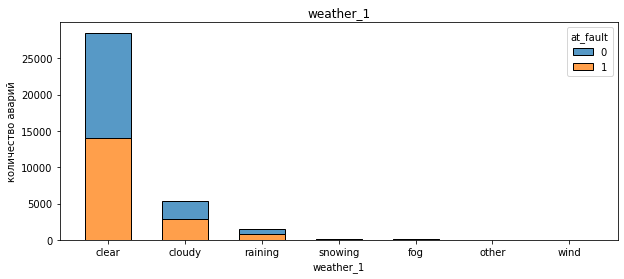

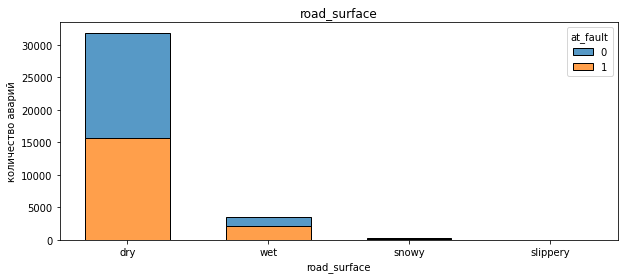

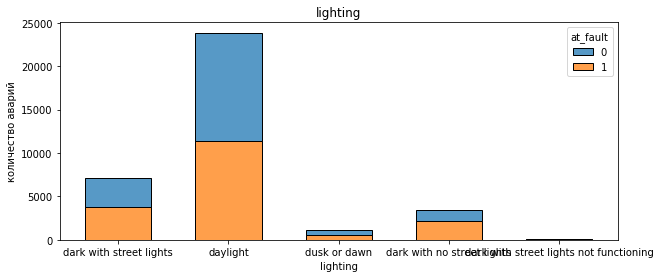

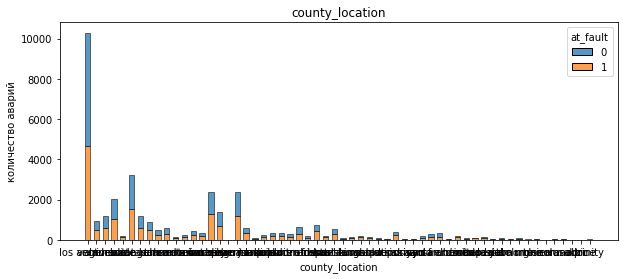

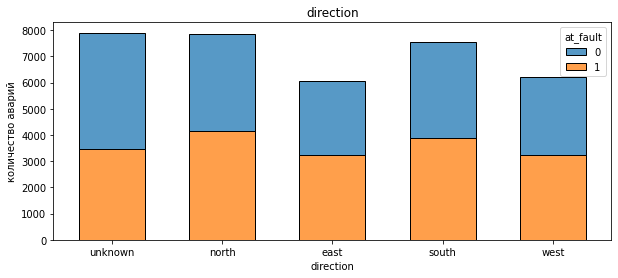

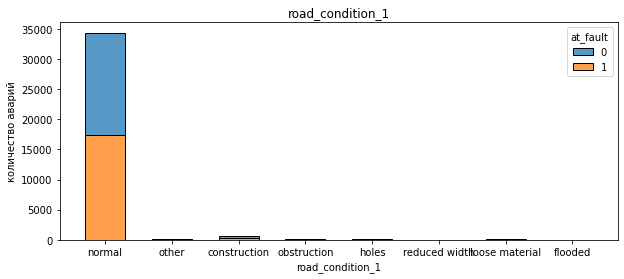

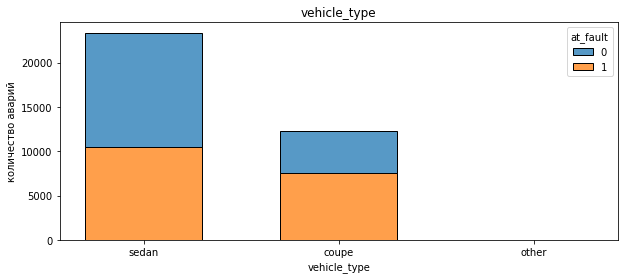

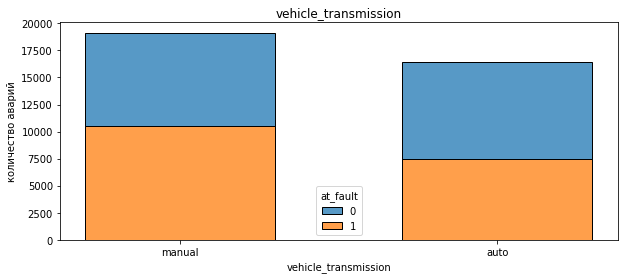

In [85]:
graf_cat(df_general_query)

In [86]:
df_general_query.query('weather_1=="other"').weather_1.count()

23

Мы видим, что в большинстве случаев погода была либо ясной, либо облачной. Остальные категории очень маленькие, можно их объединить в "плохие" погодные условия. У нас мало строк в категории "другие" погодные условия. Их можно либо удалить, либо включить в большую группу "плохие". Включим в группу непогоды



In [87]:
weather_conditions = [
    df_general_query['weather_1'].isin(['raining','snowing']),
    df_general_query['weather_1'].isin(['other', 'fog','wind']),
    df_general_query['weather_1']=='clear',
    df_general_query['weather_1']=='cloudy'
]
weather_types = ['bad', 'normal', 'clear','cloudy']
df_general_query['weather_1'] = np.select(weather_conditions,weather_types, 'другой')

In [88]:
weather_conditions_test = [
    df_general_query_test['weather_1'].isin(['raining','snowing']),
    df_general_query_test['weather_1'].isin(['other', 'fog','wind']),
    df_general_query_test['weather_1']=='clear',
    df_general_query_test['weather_1']=='cloudy'
]

df_general_query_test['weather_1'] = np.select(weather_conditions_test,weather_types, 'другой')

аналогично поступим с дорожным покрытием

In [89]:
bad_road_surface = {"wet", "slippery", "snowy"}
df_general_query["road_surface"] = (df_general_query["road_surface"]
                                    .apply(lambda x: "bad_surface" if x in bad_road_surface  else x))

df_general_query_test["road_surface"] = (df_general_query_test["road_surface"]
                                    .apply(lambda x: "bad_surface" if x in bad_road_surface  else x))

In [90]:
df_general_query.query('vehicle_type=="other"').vehicle_type.count()

1

У нас всего 2 машины с другим видом кузова, удалим их.

In [91]:
df_general_query = df_general_query.query('vehicle_type != "other"')

df_general_query_test = df_general_query_test.query('vehicle_type != "other"')

В признаке road_condition_1 тоже можно укрупнить категории

нормальная дорога - normal,

bad_road что-то с состоянием дорожного полотна(поверхности) Holes, Loose Material, Flooded (затоплено), Other (другое)

narrow (сужение проезжей части) -Obstruction on Roadway (препятствие на проезжей части), Construction or Repair Zone (зона строительства или ремонта), Reduced Roadway Width (уменьшенная ширина проезжей части)

Объединим категорию "темнота" в lighting

In [92]:
bad_lighting = {'dark with no street lights', 'dark with street lights not functioning'}
df_general_query["lighting"] = df_general_query["lighting"].apply(lambda x: 'dark' if x in bad_lighting  else x)

df_general_query_test["lighting"] = df_general_query_test["lighting"].apply(lambda x: 'dark' if x in bad_lighting  else x)

Признак country_location категориальный, содержит большое количество маленьких категорий. Возможно он будет избыточным, или его будет полезно как-то преобразовать. 

### Вывод по части исследовательский анализ данных

В блоке EDA  мы посмотрели описательную статистику, построили боксплоты и графики для числовых и категориальных данных.

*weekday_collision* дни недели от 0 до 6, медиана на 3 дне (четверг)

*hour_collision* часы аварии 0-23. Медиана в 14 (2 часа дня)

*intersection* бинарный признак. Перекрестки встречаются значительно реже чем обычная дорога.

*county_city_location* индексы. Трехзначные значения индекса (например 100) не выброс.

*distance* - расстояние от главной дороги(метры). 0 означает, что авария произошла на главной дороге. 1584000 максимальное значение дистанции - выброс, удалили его.

*at_fault*- таргет, бинарный признак. либо виновен,либо не виновен. Классы распределены почти поровну, дисбаланса нет.

*insurance_premium* сумма страховки. Кто-то без страховки, у кого-то очень дорогая. Распределение смещено влево и имеет длинный хвост справа. Максимальное значение хоть и большое, но возможное. Пока оставили и не стали удалять.

*vehicle_age* мы уже убрали выбросы при выгрузке данных. Самые новые машины (возраст 0 и 1 год) исключительно седаны. Большая часть авто возраста 3 лет


Укрупнили категории в некоторых категориальных признаках:

*weather_1* - в большинстве случаев погода была либо ясной, либо облачной. Остальные категории очень маленькие, объединили в "плохие" погодные условия.29 строк в категории "другие" погодные условия также включили в большую группу "плохие".

*road_surface* аналогично поступили с признаком 'дорожное покрытие': категории "wet", "slippery", "snowy" объединили в одну - 'bad_surface'

*vehicle_type* седаны встречаются чаще чем couple, а значение other практически не попадается.Всего 2 машины с типом кузова 'other', удалили их.

В признаке *road_condition_1* также укрупнили категории. Признаки 'holes','loose material','flooded','other' объединили в 
'bad_road'(плохое состояние поверхности дороги). А 'obstruction', 'construction','reduced width' объединили в 'narrow'(проезжая часть стала уже, пришлось объезжать)

Признак country_location категориальный, содержит большое количество маленьких категорий. Возможно он будет избыточным, или его будет полезно как-то преобразовать. 


## Корреляционный анализ

In [93]:
df_general_query

weekday_collision  hour_collision  intersection weather_1 road_surface  \
32712                  5              23             1     clear          dry   
36145                  6              20             1     clear          dry   
43                     1              13             1    cloudy          dry   
47039                  3              13             0     clear          dry   
28840                  1              15             0     clear          dry   
...                  ...             ...           ...       ...          ...   
11287                  0              15             0    cloudy          dry   
44760                  2               7             1     clear          dry   
38178                  2              10             0     clear          dry   
860                    6              18             1     clear          dry   
15801                  3              15             0     clear          dry   

                      lighting  county_city_location county_location  \
32712  dark with street lights                  1942     los angeles   
36145                 daylight                  5604         ventura   
43                    daylight                   105         alameda   
47039                 daylight                  3300       riverside   
28840                 daylight                  1912     los angeles   
...                        ...                   ...             ...   
11287                 daylight                  3610  san bernardino   
44760                 daylight                  1942     los angeles   
38178                 daylight                  1502            kern   
860    dark with street lights                  3317       riverside   
15801                 daylight                  1950     los angeles   

      direction  distance road_condition_1  insurance_premium  \
32712   unknown         0           normal               20.0   
36145   unknown         0           normal               39.0   
43      unknown         0           normal               61.0   
47039     north       700           normal               28.0   
28840      east        50           normal               30.0   
...         ...       ...              ...                ...   
11287     south        15           normal               45.0   
44760   unknown         0           normal               38.0   
38178      east       600           normal               53.0   
860     unknown         0           normal               20.0   
15801     north       660           normal               33.0   

      cellphone_in_use vehicle_type vehicle_transmission  vehicle_age  \
32712              0.0        sedan               manual            4   
36145              0.0        coupe                 auto            5   
43                 0.0        sedan               manual            3   
47039              0.0        coupe               manual            4   
28840              0.0        coupe                 auto            4   
...                ...          ...                  ...          ...   
11287              0.0        sedan                 auto            2   
44760              0.0        sedan               manual            6   
38178              0.0        sedan               manual            2   
860                0.0        sedan               manual            3   
15801              0.0        coupe                 auto            5   

       at_fault  
32712         1  
36145         0  
43            0  
47039         0  
28840         0  
...         ...  
11287         0  
44760         0  
38178         0  
860           1  
15801         0  

[35574 rows x 17 columns]

In [94]:
num_col = ['distance','insurance_premium','vehicle_age']

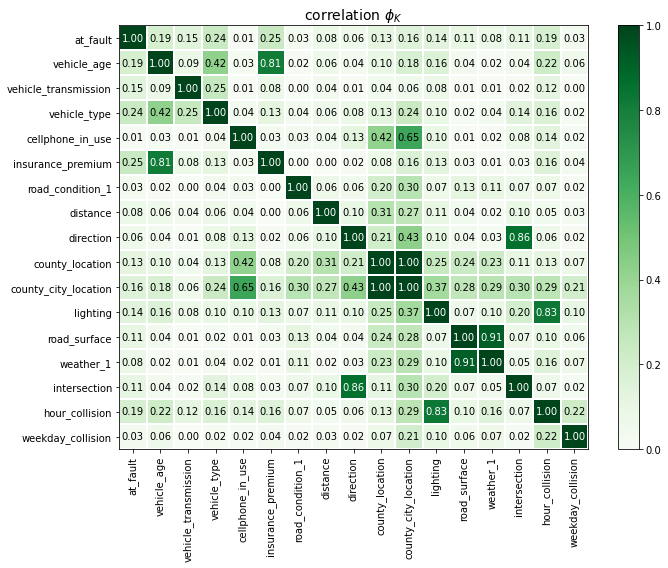

In [95]:
phik_overview = df_general_query.phik_matrix(interval_cols = num_col)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

1) признаки county_city_location и county_location мультиколлинеарны. уберем один из них ('county_location')

2) по отдельности признаки direction и county_city_location не информативны. Важно их сочетание. объединим в один признак

3)после объединения признаков direction-location мультиколлинарен с тем.является ли место аварии перекрестком. Это не очень логично, но признак с перекрестком кажется избыточным. Попробуем оставить направление

4) Казалось бы что состояние дороги должно зависеть от погоды, но не все так однозначно:
ветрянная погода у нас причислена к плохим, однако дорога сухая. может пройти дождь и выглянуть солнце: дорога скользкая, но небо ясное. 
Однако при тех погодных условиях которые точно могут мешать двиджению и ухудшать видимость(ливень,сильный снегопад) дорога ооднозначно становится опаснее. Исключение составляет туман при новомс дорожном покрытии с дренажом- видимость плохая, но сцепление по-прежнму хорошее. Попробуем не укрупнять категорию погоды. аналогично попробуем склеить погоду с дорожным покрытием. Потому что эти признаки все-таки различаются,хоть и зависят друг от друга


In [96]:
df_general_query2 = df_general_query.drop(columns='county_location')

df_general_query_test2 = df_general_query_test.drop(columns='county_location')

In [97]:
df_general_query2["direction_location"] = (df_general_query2["direction"].
                                           astype(str) + "_" + df_general_query2["county_city_location"].astype(str))

df_general_query_test2["direction_location"] = (df_general_query_test2["direction"].
                                           astype(str) + "_" + df_general_query_test2["county_city_location"].astype(str))

In [98]:
df_general_query2["weather_surface"] = (df_general_query2["weather_1"]
                                        .astype(str) + "_" + df_general_query2["road_surface"].astype(str))

df_general_query_test2["weather_surface"] = (df_general_query_test2["weather_1"]
                                        .astype(str) + "_" + df_general_query_test2["road_surface"].astype(str))

 у нас есть признак hour_collision.В теории это мог бы быть хороший признак- в часы перед рассветом водитель может быть сонным,что повышает риск аварии. Однако для рассчета вероятности аварии нам нужны данные об общем трафике в это время, потому что без этих данных количество аварий значительно ниже (меньше машин ездит) и кажется что в часы сна аварийность меньше. Но все равно этот признак достаточно информативный, т.к. показывает увеличение аварийности в часы-пик
 

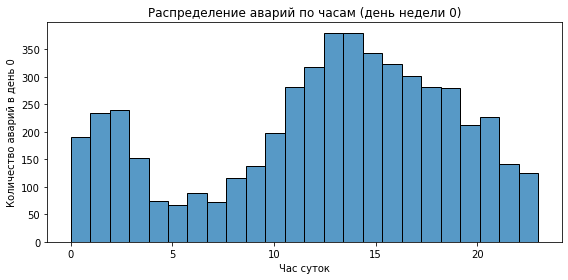

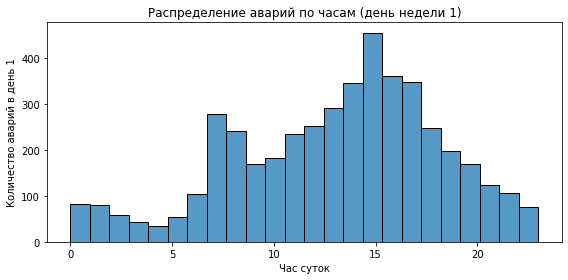

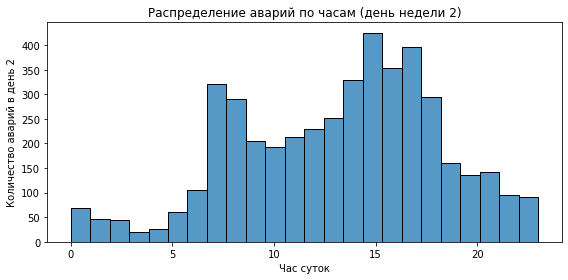

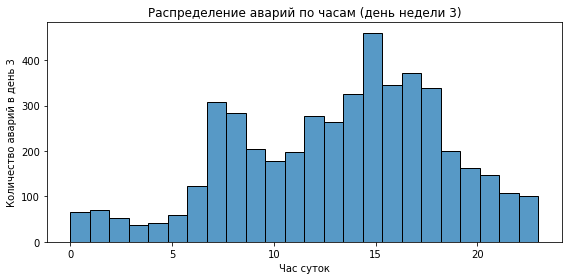

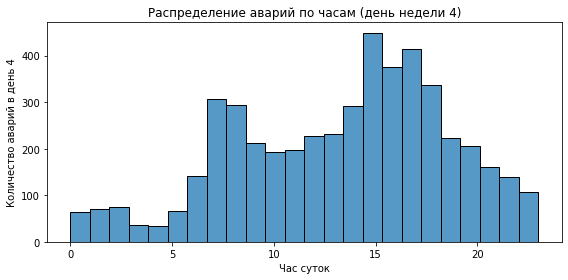

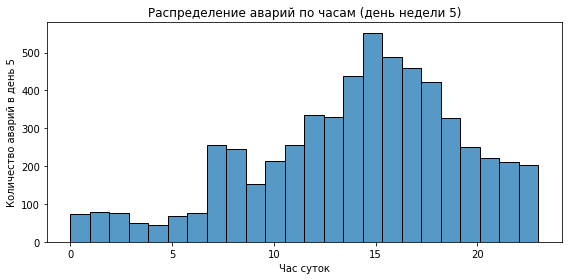

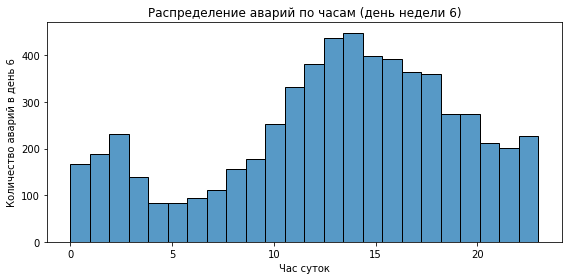

In [99]:
for num in df_general_query2.weekday_collision.sort_values().unique():
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_general_query2.query('weekday_collision == @num'), x="hour_collision", bins=24)
    plt.ylabel(f'Количество аварий в день {num}')
    plt.xlabel('Час суток')
    plt.title(f'Распределение аварий по часам (день недели {num})')
    plt.tight_layout()
    plt.show()

 мы видим, что распределение аварий от часов различается в зависимости от дня недели: по будням есть два периода (час-пик), когда количество аварий увеличивается, в выходные нет. Свяжем признаки день недели и час

In [100]:
df_general_query2["weekday_hour"] = (df_general_query2["weekday_collision"].
                                     astype(str) + "_" + df_general_query2["hour_collision"].astype(str))

df_general_query_test2["weekday_hour"] = (df_general_query_test2["weekday_collision"].
                                     astype(str) + "_" + df_general_query_test2["hour_collision"].astype(str))

наличие handsfree слабый признак. Уберем его

In [101]:
df_general_query2.drop(columns=['county_city_location',
                                'direction','intersection', 'cellphone_in_use',
                                'weather_1','road_surface',
                               'weekday_collision',
                               'hour_collision'], inplace=True)

df_general_query_test2.drop(columns=['county_city_location',
                                'direction','intersection', 'cellphone_in_use',
                                'weather_1','road_surface',
                               'weekday_collision',
                               'hour_collision'], inplace=True)

Построим матрицу корреляций заново

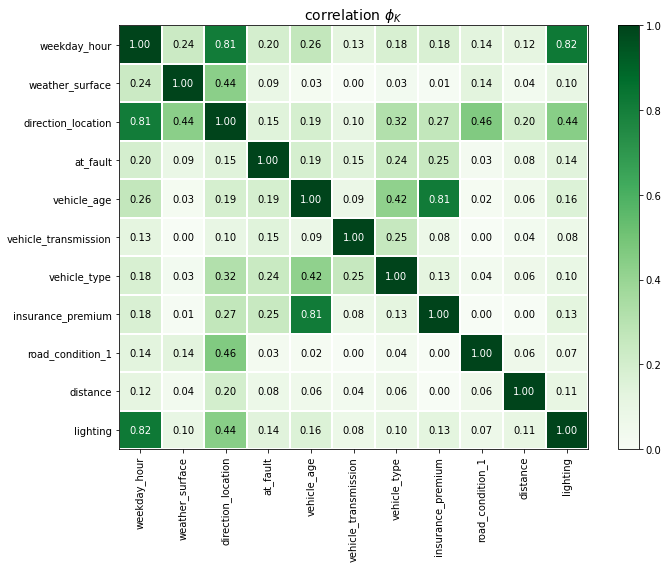

In [102]:
phik_overview = df_general_query2.phik_matrix(interval_cols = num_col)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

Попробуем пока с таким набором фичей и построим baseline модель

## baseline model

**выбор метрики**

У нас задача бинарной классификации риска ДТП, где:

- цель — оценить риск ДТП до его возникновения;
- таргет: at_fault (1 — виновен, 0 — нет);
- ошибка "пропустить вероятность быть виновником аварии" критичнее, чем ложное срабатывание.
- В нашем случае нет выраженного дисбаланса классов.

В этом случае хорошо подходят метрики:

**ROC AUC** 

она оценивает способность модели различать классы на всех уровнях порога. Не зависит от конкретного порога (в отличие от Accuracy или Precision/Recall).

и **F1-score**-  это гармоническое среднее между precision (точностью) и recall (полнотой). Нам важны оба показателя (precision и recall), но ошибки разного типа несут разную цену.

Выделим таргет в обучающей и тестовой выборках с отбранными признаками

In [103]:
X_train = df_general_query2.drop(columns=['at_fault'], axis=1)  
y_train = df_general_query2['at_fault'] 

X_test = df_general_query_test2.drop(columns=['at_fault'], axis=1)  
y_test = df_general_query_test2['at_fault'] 

В качестве базовой модели используем катбуст, т.к. у нас много категориальных признаков. Оценим важность фичей на кросс-валидации 

Fold 1 - Accuracy: 0.6504, F1: 0.6443, ROC AUC: 0.7098
Fold 2 - Accuracy: 0.6605, F1: 0.6577, ROC AUC: 0.7233
Fold 3 - Accuracy: 0.6569, F1: 0.6538, ROC AUC: 0.7147

Средние метрики по 3 фолдам:
Accuracy: 0.6559
F1 Score: 0.6520
ROC AUC: 0.7159


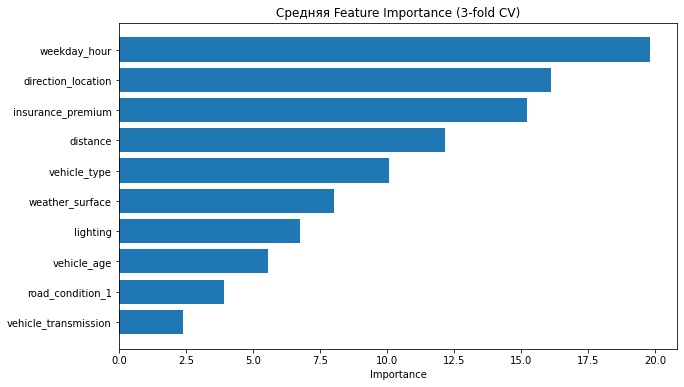

In [104]:
cat_features = ['lighting', 'road_condition_1', 'vehicle_type', 'vehicle_transmission',
                'direction_location', 'weather_surface', 'weekday_hour']
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

importances = []
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=0,
        random_seed=RANDOM_STATE
    )
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)

    fold_importance = model.get_feature_importance()
    importances.append(fold_importance)


    # Предсказания
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Метрики
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba))

    print(f"Fold {fold} - Accuracy: {accuracy_scores[-1]:.4f}, F1: {f1_scores[-1]:.4f}, ROC AUC: {roc_auc_scores[-1]:.4f}")

# Средние метрики
print("\nСредние метрики по 3 фолдам:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f}")
# Усреднение важностей по фолдам
mean_importance = np.mean(importances, axis=0)
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Средняя Feature Importance (3-fold CV)')
plt.gca().invert_yaxis()
plt.show()

У нас есть начальный скоринг от которого будем отталкиваться. Попробуем улучшить нашу модель, подобрав гиперпараметры. В качестве основной метрики возьмем roc-auc score. 

In [105]:
result = permutation_importance(model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)

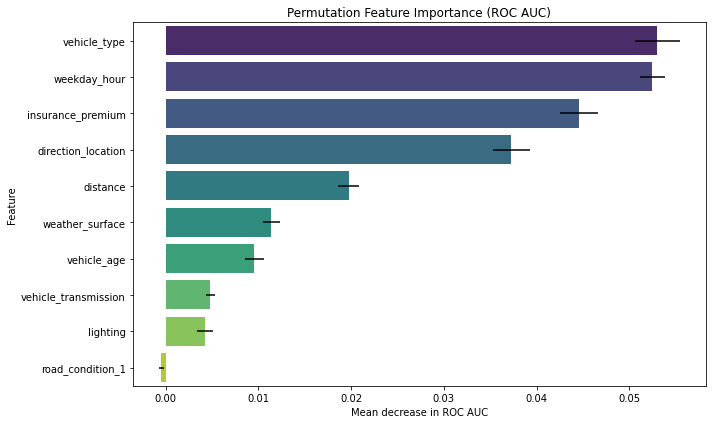

In [106]:
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance Mean',
    y='Feature',
    data=perm_importance_df,
    xerr=perm_importance_df['Importance Std'],
    palette='viridis'
)
plt.title('Permutation Feature Importance (ROC AUC)')
plt.xlabel('Mean decrease in ROC AUC')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

В целом все признаки полезны

### Подбор гиперпараметров для модели catboost

In [107]:
cat_features = ['lighting', 'road_condition_1', 'vehicle_type', 'vehicle_transmission','direction_location',
                   'weather_surface','weekday_hour']

num_features = ['distance', 'insurance_premium', 'vehicle_age']

In [108]:
model_cat = CatBoostClassifier(
    verbose=0,
    random_seed=RANDOM_STATE,
    loss_function='Logloss',
    cat_features=cat_features)
    
# Сетка параметров для перебора
param_grid = {
    'iterations': [300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1]
}

# GridSearchCV с кросс-валидацией 3 фолда
grid_search_cat = GridSearchCV(
    estimator=model_cat,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Запускаем подбор гиперпараметров
grid_search_cat.fit(X_train, y_train)

print("Лучшие параметры:", grid_search_cat.best_params_)
print("Лучшее значение roc-auc на кросс-валидации:", grid_search_cat.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ........depth=4, iterations=300, learning_rate=0.05; total time=   8.4s
[CV] END ........depth=4, iterations=300, learning_rate=0.05; total time=   8.4s
[CV] END ........depth=4, iterations=300, learning_rate=0.05; total time=   8.4s
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time=   8.5s
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time=   8.5s
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time=   8.5s
[CV] END ........depth=4, iterations=500, learning_rate=0.05; total time=  13.4s
[CV] END ........depth=4, iterations=500, learning_rate=0.05; total time=  14.2s
[CV] END ........depth=4, iterations=500, learning_rate=0.05; total time=  13.4s
[CV] END .........depth=4, iterations=500, learning_rate=0.1; total time=  13.5s
[CV] END .........depth=4, iterations=500, learning_rate=0.1; total time=  13.8s
[CV] END .........depth=4, iterations=500, learn

### Подбор гиперпараметров для модели LightGBM

Модель лайт-бустинга дает лучшие результаты без признака direction_location, в котором очень много категорий

In [109]:
X_train_lgb = X_train.drop(columns=['direction_location'], axis=1)  

X_test_lgb = X_test.drop(columns=['direction_location'], axis=1)  

cat_features_lgb = ['lighting', 'road_condition_1', 'vehicle_type', 'vehicle_transmission',
                   'weather_surface','weekday_hour']

In [110]:

X_train_lgb[cat_features_lgb] = X_train_lgb[cat_features_lgb].apply(lambda x: x.astype('category'))

model_lgb = LGBMClassifier(random_state=RANDOM_STATE)

param_distributions = {  
        'n_estimators': [300, 400, 500],
        'max_depth': [3, 6, 8],
        'learning_rate': [0.05, 0.1]}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

search_lgb = RandomizedSearchCV(
        estimator=model_lgb,
        param_distributions=param_distributions,
        scoring=scoring,
        cv=3,
        n_iter=10,
        random_state=RANDOM_STATE,
        refit='roc_auc')


search_lgb.fit(X_train_lgb, y_train, categorical_feature=cat_features_lgb)


    # Получаем лучшую модель
best_model_lgb = search_lgb.best_estimator_

cv_results = search_lgb.cv_results_

# Выводим метрики для лучшей модели
best_model_index = search_lgb.best_index_  # Индекс для лучшей модели


best_accuracy = cv_results['mean_test_accuracy'][best_model_index]
best_f1 = cv_results['mean_test_f1'][best_model_index]
best_roc_auc = cv_results['mean_test_roc_auc'][best_model_index]

print(f"Кросс-валидация: Accuracy: {best_accuracy:.4f}")
print(f"Кросс-валидация: F1 Score: {best_f1:.4f}")
print(f"Кросс-валидация: ROC AUC: {best_roc_auc:.4f}")

print("Лучшие параметры:", search_lgb.best_params_)

Кросс-валидация: Accuracy: 0.6269
Кросс-валидация: F1 Score: 0.6190
Кросс-валидация: ROC AUC: 0.6723
Лучшие параметры: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [111]:
X_test_lgb[cat_features_lgb] = X_test_lgb[cat_features_lgb].apply(lambda x: x.astype('category'))

y_pred_lgb = best_model_lgb.predict(X_test_lgb)
y_proba_lgb = best_model_lgb.predict_proba(X_test_lgb)[:, 1]  # вероятности для ROC AUC

test_accuracy = accuracy_score(y_test, y_pred_lgb)
test_f1 = f1_score(y_test, y_pred_lgb)
test_roc_auc = roc_auc_score(y_test, y_proba_lgb)

print("Результаты на тесте:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"F1 Score:  {test_f1:.4f}")
print(f"ROC AUC:   {test_roc_auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))

Результаты на тесте:
Accuracy:  0.6256
F1 Score:  0.6108
ROC AUC:   0.6733
Confusion Matrix:
 [[5056 2508]
 [3196 4475]]


### Подбор гиперпараметров для нейросети

Попробуем нейросеть. Подготовим признаки (нормализуем и закодируем). Работаем с теми же признаками, что и для лайтбуста

In [112]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse=False, drop='first'),cat_features_lgb)
    ]
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])


X_train_processed = full_pipeline.fit_transform(X_train_lgb)
X_test_processed = full_pipeline.transform(X_test_lgb)


cat_features_names = preprocessor.named_transformers_['cat'].get_feature_names(cat_features_lgb)
all_features = list(num_features) + list(cat_features_names)

X_train_df = pd.DataFrame(X_train_processed, columns=all_features)
X_test_df = pd.DataFrame(X_test_processed, columns=all_features)

In [113]:
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

Преобразуем в тензоры

In [114]:
X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)

In [115]:
input_size = X_train_tensor.shape[1]
input_size

189

In [116]:

class CustomNet(NeuralNetClassifier):
    def predict_proba(self, X):
        self.module_.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X.astype(np.float32))
            logits = self.forward(X_tensor)
            probs = torch.sigmoid(logits).numpy().flatten()
            return np.vstack([1 - probs, probs]).T  
        
class CollisionNet(nn.Module):
    def __init__(self, input_size, hidden1=100, hidden2=32, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.LeakyReLU()
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.relu2 = nn.SiLU()
        
        self.fc3 = nn.Linear(hidden2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        return x  
    
    
X_np = X_train_tensor.numpy().astype('float32') 
y_np =  y_train.values.astype('float32').reshape(-1, 1)    

# Callbacks для логирования метрик
valid_auc = EpochScoring(scoring='roc_auc', lower_is_better=False, name='val_roc_auc')
valid_f1 = EpochScoring(scoring='f1', lower_is_better=False, name='val_f1')

# Инициализация модели
net = CustomNet(
    CollisionNet,
    module__input_size=X_np.shape[1],
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=90,
    lr=0.0005,
    batch_size=32,
    iterator_train__shuffle=True,
    train_split=None,
    verbose=1,
    callbacks=[valid_auc, valid_f1],
    device='cpu'
)

# Подбор гиперпараметров
params = {
    'module__dropout_rate': [0.15, 0.2],
    'lr':[0.0008],
    'batch_size': [32, 38],
}

f1_scorer = make_scorer(f1_score)

gs = GridSearchCV(
    net,
    params,
    scoring='roc_auc', 
    cv=3,
    verbose=2
)

gs.fit(X_np, y_np)

print("Best Parameters:", gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6554  6.0691
      2        0.6402  5.5768
      3        0.6358  5.3119
      4        0.6326  5.5954
      5        0.6293  5.7015
      6        0.6256  5.3831
      7        0.6214  5.4029
      8        0.6175  5.6060
      9        0.6135  5.3015
     10        0.6099  5.3832
     11        0.6059  5.8030
     12        0.6016  5.4865
     13        0.5973  5.2254
     14        0.5932  6.6105
     15        0.5891  6.2012
     16        0.5850  5.3023
     17        0.5820  5.3929
     18        0.5772  5.6902
     19        0.5729  5.3046
     20        0.5696  5.4857
     21        0.5643  5.2030
     22        0.5601  5.4052
     23        0.5567  5.4990
     24        0.5509  5.4013
     25        0.5469  5.4859
     26        0.5423  5.6030
     27        0.5362  5.3847
     28        0.5324  5.4113
     29        0.5300  5.7819
     30   

## Выбираем лучшую модель

In [117]:
# У нас была ошибка из-за категориальных фичей, поэтому f1 для катбуста посчитаем так

categorical_features = cat_features 
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

model_cat = grid_search_cat.best_estimator_  #берем нашу подобранную модель для катбуста


f1_scores = cross_val_score(
    model_cat,
    X_train,
    y_train.values.ravel(),
    cv=stratified_cv,
    scoring='f1')

print("F1 по фолдам:", f1_scores)
print("Среднее F1:", f1_scores.mean())

F1 по фолдам: [0.65177421 0.65494803 0.65041902]
Среднее F1: 0.652380417470365


In [118]:
# CatBoost
roc_auc_cat = grid_search_cat.best_score_  # ROC AUC при подборе
params_cat = grid_search_cat.best_params_

#LightGBM
f1_lgb = cross_val_score(best_model_lgb, X_np, y_np, cv=3, scoring='f1').mean()
roc_auc_lgb = search_lgb.best_score_  # ROC AUC при подборе
params_lgb = search_lgb.best_params_

# Skorch NeuralNet 
f1_skorch = cross_val_score(gs.best_estimator_, X_np, y_np, cv=3, scoring='f1').mean()
roc_auc_skorch = gs.best_score_  # roc_auc при подборе
params_skorch = gs.best_params_

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6562  5.3862
      2        0.6418  5.2112
      3        0.6361  5.6100
      4        0.6330  5.4071
      5        0.6291  5.5847
      6        0.6254  5.3158
      7        0.6209  5.3842
      8        0.6168  5.3970
      9        0.6130  5.6038
     10        0.6076  5.2957
     11        0.6032  5.5065
     12        0.5998  6.7149
     13        0.5948  5.3002
     14        0.5902  5.2956
     15        0.5868  5.4048
     16        0.5819  5.4187
     17        0.5779  5.4822
     18        0.5737  5.3978
     19        0.5692  5.5127
     20        0.5647  5.5821
     21        0.5607  5.3979
     22        0.5555  5.7960
     23        0.5518  5.5147
     24        0.5491  5.9917
     25        0.5448  5.5986
     26        0.5406  5.3927
     27        0.5378  5.2130
     28        0.5325  5.2076
     29        0.5302  5.4073
     30        0.5257  5.5018
     31        0.5218  5.7844
     32   

Соберем таблицу сравнения:

In [119]:
comparison_table = pd.DataFrame([
    {
        'Модель': 'CatBoost',
        'F1-score (CV)': round(f1_scores.mean(), 4),
        'ROC-AUC (CV)': round(roc_auc_cat, 4),
        'Лучшие параметры': str(params_cat),
        'Метрика выбора': 'ROC AUC'
    },
    {
        'Модель': 'LightGBM',
        'F1-score (CV)': round(f1_lgb, 4),
        'ROC-AUC (CV)': round(roc_auc_lgb, 4),
        'Лучшие параметры': str(params_lgb),
        'Метрика выбора': 'ROC AUC'
    },
    {
        'Модель': 'Skorch NeuralNet',
        'F1-score (CV)': round(f1_skorch, 4),
        'ROC-AUC (CV)': round(roc_auc_skorch, 4),
        'Лучшие параметры': str(params_skorch),
        'Метрика выбора': 'ROC AUC' 
    }
])

display(comparison_table)

Модель  F1-score (CV)  ROC-AUC (CV)  \
0          CatBoost         0.6524        0.7191   
1          LightGBM         0.6280        0.6723   
2  Skorch NeuralNet         0.5809        0.6076   

                                    Лучшие параметры Метрика выбора  
0  {'depth': 4, 'iterations': 500, 'learning_rate...        ROC AUC  
1  {'n_estimators': 300, 'max_depth': 3, 'learnin...        ROC AUC  
2  {'batch_size': 32, 'lr': 0.0008, 'module__drop...        ROC AUC

Исходя из результатов моделей, мы видим что катбуст лучше справляется с условиями нашей задачи. 
Проверим работу модели на тесте:

In [120]:
best_model_cat = grid_search_cat.best_estimator_

In [121]:
y_pred = best_model_cat.predict(X_test)
y_proba = best_model_cat.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print("Accuracy на тесте:", accuracy_score(y_test, y_pred))
print("F1 на тесте:", f1_score(y_test, y_pred))
print("ROC AUC на тесте:", roc_auc_score(y_test, y_proba))
print("Precision на тесте:",precision)
print("Recall на тесте:", recall)
print("Confusion Matrix:\n", cm)

Accuracy на тесте: 0.6667541844437151
F1 на тесте: 0.6610588156752788
ROC AUC на тесте: 0.724150233136799
Precision на тесте: 0.6774767378215654
Recall на тесте: 0.6454178073262938
Confusion Matrix:
 [[5207 2357]
 [2720 4951]]


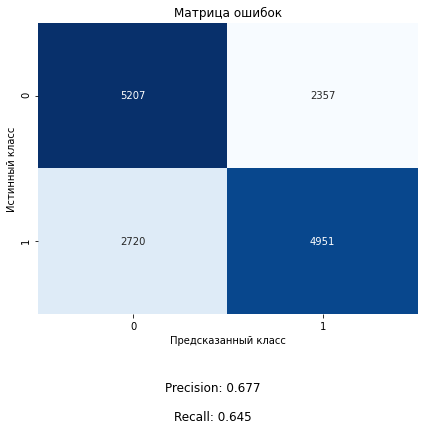

In [122]:
# Визуализация матрицы ошибок
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

# Подписи по метрикам
plt.figtext(0.5, -0.1, f'Precision: {precision:.3f}', ha='center', fontsize=12)
plt.figtext(0.5, -0.18, f'Recall: {recall:.3f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Точность низковата. Из всех объектов,которые модель предсказала как положительные только 67% действительно такие.  Из всех настоящих положительных объектов модель смогла правильно найти примерно 64.3%.

Ранее мы исследовали важность признаков, когда делали отбор.

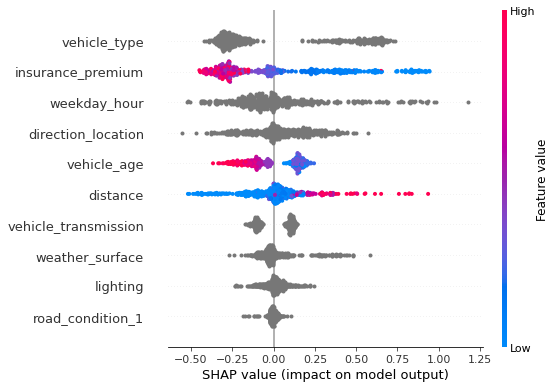

In [123]:
X_sampled = resample(X_test, n_samples=500, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(best_model_cat)
shap_values = explainer.shap_values(X_sampled)
shap.summary_plot(shap_values, X_sampled, feature_names=X_sampled.columns)

низкое значение страховки повышает вероятность класса 1, высокое значение страховки сдвигает предикт к 0

большая дистанция увеличивает риск быть виновником аварии(смещает предикт к 1)

более старые авто реже являются виновником аварии (больше возраст смещает предикт к 0)

мы видим, что тип подвески довольно четко разделен, но не можем утверждать в какую сторону смещается вероятность класса. 

 Посмотрим как признаки влияют на конкретное предсказание

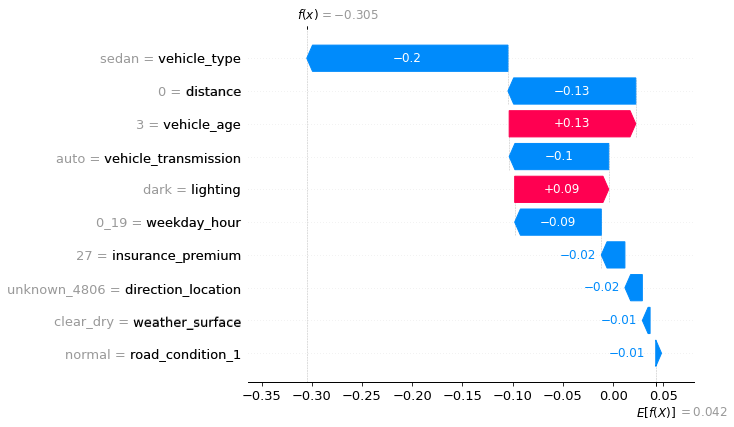

In [124]:
x_single = X_test.iloc[[0]] 
shap_values = explainer(x_single)

# 3. Визуализация влияния признаков
shap.plots.waterfall(shap_values[0])  # Для одного примера

У страховки низкое значение 20(сдвинуло предикт вправо)
возраст авто-2 года, маленький. тоже сдвигает предикт вправо
distance=0 это не выброс, это значит авария произошла на главной дороге (признак показывает расстояние от главной дороги)- смещает влево
направление движения и точка отсчета - сдвигает предикт влево
время поездки (день недели и час) воскресенье 10 утра-  тоже смещает влево
седан - слабо влево
все остальные признаки влияют совсем мало

Не сказать что у нас есть хорошая модель и сильные признаки, которые четко влияют на определение риска аварии. Но суммируя результаты feature importance, permutation imoptance (выше в отборе признаков), а также графики shap (beeswarm и waterfall) мы можем выделить несколько значимых фичей:

самое большое влияние на всех графиков показывает признак insurance_premium, а также weekday_hour и  vehicle_type. Также неплохая значимость у признака direction_location

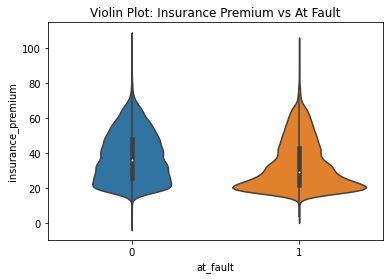

In [125]:
sns.violinplot(x='at_fault', y='insurance_premium', data=df_general_query2)
plt.title("Violin Plot: Insurance Premium vs At Fault")
plt.show()

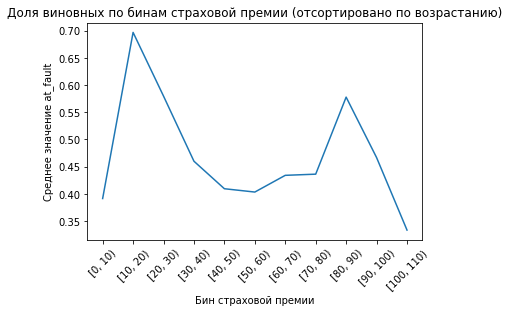

In [126]:
bins = np.arange(0, 111, 10)
df_general_query2['premium_bin'] = pd.cut(df_general_query2['insurance_premium'], bins=bins, right=False)
df_general_query2['premium_bin_str'] = df_general_query2['premium_bin'].astype(str)
grouped = df_general_query2.groupby('premium_bin', observed=True)['at_fault'].mean().reset_index()
grouped['premium_bin_str'] = grouped['premium_bin'].astype(str)

sns.lineplot(x='premium_bin_str', y='at_fault', data=grouped)
plt.xticks(rotation=45)
plt.title("Доля виновных по бинам страховой премии (отсортировано по возрастанию)")
plt.xlabel("Бин страховой премии")
plt.ylabel("Среднее значение at_fault")
plt.show()

мы видим, что при небольшой страховке виновников аварии значительно больше, также как и при самой высокой. Возможно признак страховки. По графику violin plot мы видим резкое увеличение виновников аварии со значением страховки 20. 

К сожалению размер страховки никак не связан с оборудованием авто

## Выводы

В ходе проведенного исследования были выполнены следующие этапы:

- Импортированы нужные библиотеки, определены константы
- выполнено подключение к базе, частичная загрузка таблиц sql, первичное исследование таблиц. Определены необходимые таблицы для работы
- Проведен статистический анализ факторов ДТП:

1) выяснили в какие месяцы происходит наибольшее количество аварий. В таблице есть данные, предоставленные за неполный период (2012,2013 и даже несколько строк за 2020 года)
Для более точного анализа построили совмещенный график по годам. На графике видно, что с 6 го месяца(включительно) 2012 года количество аварий становится значительно меньше. Это может означать как неполную информацию за год (не все данные были предоставлены), так и снижение аварий благодаря дорожным реформам, которые активно вводились в 2012. Рассматривая только полные данные за периоды (2009-2011 года) можно заключить, что сезонность влияет на дорожную ситуацию не так сильно,как казалось изначально. Максимальное количество аварий наблюдается в октябре-декабре

2) были поставлены задачи для более подробной оценки факторов ДТП:

* анализ серьёзности повреждений транспортного средства, исходя из состояния дороги
* найти самые частые причины ДТП
* оценить взаимосвязь серьезности аварии от физического состояния водителя
* исследовать в какое время наблюдается пиковое значение количества аварий. В какое время происходят наиболее серьезные аварии
* как количество аварий зависит от возраста автомобиля? Как старые авто справляются с плохим состоянием дороги?
* рассмотреть как погода влияет на аварийность? Оценить количество аварий в зависимости от погоды, какие виды автомобилей хуже справляются с непогодой

При оценке взаимосвязи серьезности аварии от физического состояния водителя были сделаны следующие выводы:

Самая большая категория в физическом состоянии водителей - это возможное ухудшение состояния (т.е. не определено точно, было ухудшение или нет). Во всех случаях бОльшая часть аварий заканчивалась легим уроном, особенно в этой категории - больше 2/3.   
В случае сонного состояния водителей или действительно наступившего физического ухудшения большинство аварий тоже заканчивались с легким уроном или царапинами.
Однако можно отметить, что в столбце с фатальным исходом больше 50% водителей находились под воздействием лекарственных препаратов. В столбце с сильной степенью серьезности аварии водители под воздейситвием лекарств занимают около 13,5%, а со средней - 12%. Таким образом можно заключить, что **прием лекарств значительно увеличивает риск серьезной аварии.**

**Сонное состояние водителя реже**, чем воздействие лекарств, **приводит к сильно негативным последствиям**: большинство аварий с участием сонного водителя оборачиваются маленькими повреждениями или царапинами, реже средними. Серьезные повреждения и фатальные случаи крайне редки

В большинстве случаев водители были трезвыми. Однако в случае фатальной аварии или сильного повреждений автомобиля доля пьяных водителей намного больше. Можно заключить, что **алкоголь может значительно увеличить риск серьезной аварии**


При исследовании шестой задачи результаты удивили: в процентном соотношении **старые авто справляются с плохими погодными условиями не хуже (а даже незначительно лучше, чем более новые машины)**.  

3)  По запросу заказчика были сформулированы *критерии, удотвлетворяющие условию нашей задачи* (исследование риска аварии для каршеринговой компании) для SQL запроса

Для модели выбрать тип виновника — только машина (car). Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина). Для моделирования ограничиться данными за 2012 год — они самые свежие. Обязательное условие — учесть фактор возраста автомобиля. 

В нашем датасете мы выгрузили данные только для автомобилей,  возраст которых не превышает 10 лет. Т.к. каршеринговые компании обычно не используют старые авто.

Далее были выполнены стандартные этапы для построения модели:

1) Выполнена *предобработка данных*.  Проверили названия столбцов, поменяли тип данных в столбцах,которых это было необходимо. Удалили явные дубликаты и исправили разночтения. Заполнили пропуски 

2) В *блоке EDA*  мы посмотрели описательную статистику, построили боксплоты и графики для числовых и категориальных данных.

**weekday_collision** дни недели от 0 до 6, медиана на 3 дне (четверг)

**hour_collision** часы аварии 0-23. Медиана в 14 (2 часа дня)

**intersection** бинарный признак. Перекрестки встречаются значительно реже чем обычная дорога.

**county_city_location** индексы. Трехзначные значения индекса (например 100) не выброс.

**distance** - расстояние от главной дороги(метры). 0 означает, что авария произошла на главной дороге. 1584000 максимальное значение дистанции - выброс, удалили его.

**at_fault**- таргет, бинарный признак. либо виновен,либо не виновен. Классы распределены почти поровну, дисбаланса нет.

**insurance_premium** сумма страховки. Кто-то без страховки, у кого-то очень дорогая. Распределение смещено влево и имеет длинный хвост справа. Максимальное значение хоть и большое, но возможное. Пока оставили и не стали удалять.

**vehicle_age** мы уже убрали выбросы при выгрузке данных. Самые новые машины (возраст 0 и 1 год) исключительно седаны. Большая часть авто возраста 3 лет


Укрупнили категории в некоторых категориальных признаках:

**weather_1** - в большинстве случаев погода была либо ясной, либо облачной. Остальные категории очень маленькие, объединили в "плохие" погодные условия.29 строк в категории "другие" погодные условия также включили в большую группу "плохие".

**road_surface** аналогично поступили с признаком 'дорожное покрытие': категории "wet", "slippery", "snowy" объединили в одну - 'bad_surface'

**vehicle_type** седаны встречаются чаще чем couple, а значение other практически не попадается.Всего 2 машины с типом кузова 'other', удалили их.

В признаке **road_condition_1** также укрупнили категории. Признаки 'holes','loose material','flooded','other' объединили в 
'bad_road'(плохое состояние поверхности дороги). А 'obstruction', 'construction','reduced width' объединили в 'narrow'(проезжая часть стала уже, пришлось объезжать)

Признак **country_location** категориальный, содержит большое количество маленьких категорий.

3) Провели *корреляционный анализ* признаков.

- признаки county_city_location и county_location мультиколлинеарны. убрали ('county_location')

- по отдельности признаки direction и county_city_location не информативны. Важно их сочетание. объединили в один признак

- после объединения признаков direction-location мультиколлинарен с intersection.Убрали признак с перекрестком (у него была слабая корреляция с таргетом)

- казалось бы что состояние дороги должно зависеть от погоды, но не все так однозначно: ветрянная погода у нас причислена к плохим, однако дорога сухая. может пройти дождь и выглянуть солнце: дорога скользкая, но небо ясное. Однако при тех погодных условиях которые точно могут мешать движению и ухудшать видимость(ливень,сильный снегопад) дорога ооднозначно становится опаснее. Исключение составляет туман при новомс дорожном покрытии с дренажом- видимость плохая, но сцепление по-прежнму хорошее.  Совместили погоду с дорожным покрытием.

- выяснили, что распределение аварий от часов различается в зависимости от дня недели: по будням есть два периода (час-пик), когда количество аварий увеличивается, в выходные нет. Объединили признаки день недели и час

В итоговом датасете для модели у нас получилось 10 признаков и таргет

В качестве baseline модели взяли катбуст.
Исходя из того, что у нас задача бинарной классификации риска ДТП (без дисбаланса классов), где ошибка "пропустить вероятность быть виновником аварии" критичнее, чем ложное срабатывание взяли за основную метрику roc-auc, также во всех моделях оценивали f1.
На основе baseline модели посмотрели feature Importance. Выяснили что наша базовая модель опиралась в большей степени на такие признаки как weekday_hour, insurance_premium, direction_location. Наиболее слабыми признаками были road-condition_1 и vehicle_transmission

Также с помощью permitation importance убедились, что признаков, которые ухудшают работу модели нет. Однако road_condition очень слабо влияет на скоринг. 
Далее обучили три модели с кросс-валидацией на 3 фолдах с подбором гиерпараметров: катбуст, лайтбуст и нейросеть.  Собрали данные о моделях в таблицу (f1, roc-auc и параметры эстиматора). В сравнительной таблице видно, что лучшие результаты показала модель катбуста (параметры: {'depth': 4, 'iterations': 500, 'learning_rate': 0.05}, лучшее значение roc-auc на кросс-валидации: 0.72). Проверив работу модели на тесте и построив confusion matrix можно сделать вывод, что точность модели недостаточно высокая. Из всех объектов,которые модель предсказала как положительные только 67% действительно такие(precision) . Из всех настоящих положительных объектов модель смогла правильно найти примерно 64.3% (recall).

С помощью shap оценили вклад признаков:
- низкое значение *insurance_premium* повышает вероятность класса 1, высокое значение страховки сдвигает предикт к 0
- большая дистанция увеличивает риск быть виновником аварии(смещает предикт к 1)
- более старые авто реже являются виновником аварии (больше возраст смещает предикт к 0)
- тип подвески довольно четко разделен, но не можем утверждать в какую сторону смещается вероятность класса (т.к. нет цветового определения для категориального признака).

Самое большое влияние на всех графиках показывает признак insurance_premium, а также weekday_hour и vehicle_type. Также неплохая значимость у признака direction_location

**Заключение** на данный момент точность построенной модели недостаточно высока, чтобы успешно использоваться в каршеринге. Однако возможно после выполнения рекомендаций и сбора недостающих данных точность удастся увеличить. 

**Рекомендации**: 
В датасете собранны неполные данные за период,  что влияет на работу модели. Добавить полные данные (хотя бы за 2012 год). В идеале для построения более точной модели предоставить полные данные за период 2013 года или позднее.

Также было бы полезно добавить данные об общем трафике (например по часам) для оценки именно риска попасть в аварию, а не риска быть виновником аварии.

Физическое состояние водителя (в том числе алкогольное) - важный фактор. Однако сейчас его сложно оценить. Неплохо бы перед поездкой как-то его замерять. Уровень алкогольного опьянения можно замерять используя алкотестер, а физическое состояние можно оценивать с помощью специально разработанного небольшого опросника (по типу опросника на определение депрессии и т.д.)